In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/chandniagarwal/Gan_Classifier.git

Cloning into 'Gan_Classifier'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 70 (delta 19), reused 65 (delta 14), pack-reused 0
Receiving objects: 100% (70/70), 3.85 MiB | 31.32 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [ ]:
!mkdir training
!cp -r /content/drive/MyDrive/researchwork_15.9.203/training_dataset/recon /content/training/recon
!cp -r /content/drive/MyDrive/researchwork_15.9.203/training_dataset/celebagt /content/training/ground
!cp -r /content/drive/MyDrive/researchwork_15.9.203/testing /content/testing

In [ ]:
import sys
sys.path.append('/content/Gan_Classifier/src')
import glob
import os
import numpy as np
import cv2
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import *
from keras import optimizers


from keras.models import Sequential
from keras.layers import Input, Dense, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

import time
import random
import seaborn as sns
from DatasetCreation import DatasetCreation
from Model import Model
from ElmModel import elm
from numba import cuda

In [ ]:
tf.random.set_seed(
    42
)
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
list_images=[]
labels=[]

In [ ]:
# Testing Data Location
test_gt = "/content/drive/MyDrive/researchwork_15.9.203/testing/gt"
test_gen = "/content/drive/MyDrive/researchwork_15.9.203/testing/gen"
test_ec = "/content/drive/MyDrive/researchwork_15.9.203/testing/ec"
test_vqvae = "/content/drive/MyDrive/researchwork_15.9.203/testing/vqvae"
test_mask = "/content/drive/MyDrive/imageclassificationmodel/dataset/mask2000"
test_unmask = "/content/drive/MyDrive/imageclassificationmodel/dataset/gt2000"

In [ ]:
# test_gt = '/content/drive/MyDrive/imageclassificationmodel/dataset/pixgan20epochs/e3'
# test_vqvae='/content/drive/MyDrive/imageclassificationmodel/dataset/pixgan20epochs/g3'

In [ ]:
# Training Data Location
train_gt='/content/training/ground'
train_recon='/content/training/recon'

In [ ]:
# training Data
image_loc_ground = glob.glob(train_gt+"/*.jpg")
labels = len(image_loc_ground) * ["ground"]
image_loc_recon = glob.glob(train_recon+"/*.jpg")

labels += len(image_loc_recon) * ["recon"]
image_loc = image_loc_ground + image_loc_recon

training_dataset = DatasetCreation(image_loc, labels, "binary")
# for 152 layer
training_dataset_152_layer = DatasetCreation(
    image_loc, labels, "binary", tf.keras.applications.resnet50.preprocess_input
)
print(training_dataset.images.shape)
print(training_dataset.labels.shape)

_________Loading Images__________


100%|██████████| 7178/7178 [00:24<00:00, 294.19it/s]


_________Loading Images__________


100%|██████████| 7178/7178 [00:14<00:00, 485.82it/s]


(7178, 224, 224, 3)
(7178,)


## load model

In [ ]:
def load_model(model_function, layers_to_train):
  start = time.time()
  # load resnet model
  base_model = model_function(
      input_shape=(224,224,3),
      include_top=False,
      weights='imagenet'
  )

  for layer in base_model.layers:
      layer.trainable = False

  for layer in layers_to_train:
    base_model.get_layer(layer).trainable = True


  # Create your binary classification layers on top of the base model
  x = base_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Add a global average pooling layer
  x = tf.keras.layers.Dense(1000, activation='relu')(x) # intermediate hidden layer
  x = tf.keras.layers.Dropout(0.2)(x)
  predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Binary classification output layer

  # Combine the base model and your custom layers into a new model
  model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

  print('Running time: %.4f seconds' % (time.time()-start))
  return model

In [ ]:
model_resnet_152_full = load_model(tf.keras.applications.ResNet152, ["conv5_block3_3_bn", "conv5_block3_3_conv"])
model_resnet_101_full = load_model(tf.keras.applications.ResNet101, ["conv5_block3_3_bn", "conv5_block3_3_conv"])
model_resnet_50_full = load_model(tf.keras.applications.ResNet50, ["conv5_block3_3_bn", "conv5_block3_3_conv"])
model_vgg_16_full = load_model(tf.keras.applications.vgg16.VGG16, ["block5_conv3"])
model_vgg_19_full = load_model(tf.keras.applications.vgg19.VGG19, ["block5_conv3"])

model_resnet_152_freeze = load_model(tf.keras.applications.ResNet152, [])
model_resnet_101_freeze = load_model(tf.keras.applications.ResNet101, [])
model_resnet_50_freeze = load_model(tf.keras.applications.ResNet50, [])
model_vgg_16_freeze = load_model(tf.keras.applications.vgg16.VGG16, [])
model_vgg_19_freeze = load_model(tf.keras.applications.vgg19.VGG19, [])

234698864/234698864 [==============================] - 11s 0us/step
Running time: 18.7656 seconds
171446536/171446536 [==============================] - 9s 0us/step
Running time: 13.0233 seconds
94765736/94765736 [==============================] - 5s 0us/step
Running time: 7.5873 seconds
58889256/58889256 [==============================] - 3s 0us/step
Running time: 4.0129 seconds
80134624/80134624 [==============================] - 5s 0us/step
Running time: 5.7160 seconds
Running time: 4.9091 seconds
Running time: 3.1488 seconds
Running time: 1.6264 seconds
Running time: 0.3402 seconds
Running time: 0.4361 seconds


In [ ]:
model_softmax = {
    "Resnet_152_full": model_resnet_152_full,
    "Resnet_101_full": model_resnet_101_full,
    "Resnet_50_full": model_resnet_50_full,
    "Resnet_152_freeze": model_resnet_152_freeze,
    "Resnet_101_freeze": model_resnet_101_freeze,
    "Resnet_50_freeze": model_resnet_50_freeze,
    "VGG_16_full": model_vgg_16_full,
    "VGG_19_full": model_vgg_19_full,
    "VGG_16_freeze": model_vgg_16_freeze,
    "VGG_19_freeze": model_vgg_19_freeze,
}
model_data = {
    "Resnet_152_full": training_dataset_152_layer,
    "Resnet_101_full": training_dataset,
    "Resnet_50_full": training_dataset,
    "Resnet_152_freeze": training_dataset_152_layer,
    "Resnet_101_freeze": training_dataset,
    "Resnet_50_freeze": training_dataset,
    "VGG_16_full": training_dataset,
    "VGG_19_full": training_dataset,
    "VGG_16_freeze": training_dataset,
    "VGG_19_freeze": training_dataset,
}

## Training

__________ Resnet_152_full __________________________________________________
Epoch 1/25
90/90 [==============================] - 36s 165ms/step - loss: 0.6649 - accuracy: 0.7429 - val_loss: 0.5049 - val_accuracy: 0.7201 - lr: 0.0010
Epoch 2/25
90/90 [==============================] - 9s 98ms/step - loss: 0.3650 - accuracy: 0.8396 - val_loss: 0.4894 - val_accuracy: 0.7465 - lr: 0.0010
Epoch 3/25
90/90 [==============================] - 7s 83ms/step - loss: 0.2868 - accuracy: 0.8776 - val_loss: 0.6770 - val_accuracy: 0.6929 - lr: 0.0010
Epoch 4/25
90/90 [==============================] - 7s 82ms/step - loss: 0.2327 - accuracy: 0.9020 - val_loss: 0.5683 - val_accuracy: 0.7486 - lr: 0.0010
Epoch 5/25
90/90 [==============================] - 7s 82ms/step - loss: 0.1822 - accuracy: 0.9255 - val_loss: 0.5973 - val_accuracy: 0.7799 - lr: 0.0010
Epoch 6/25
90/90 [==============================] - 9s 97ms/step - loss: 0.1576 - accuracy: 0.9361 - val_loss: 0.4439 - val_accuracy: 0.8175 - lr: 0.0

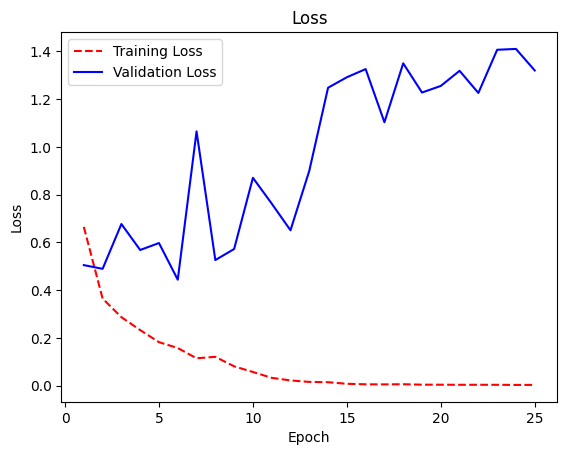

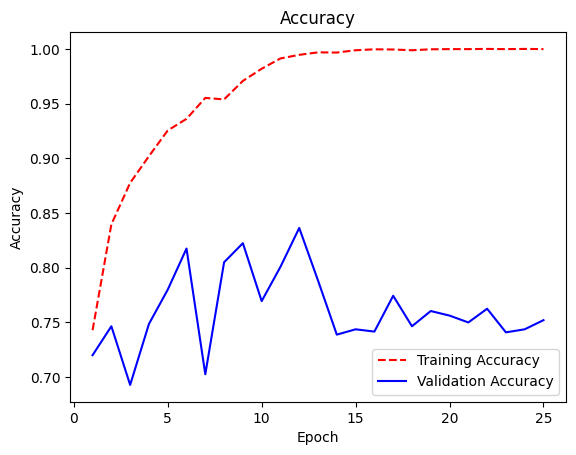

Epoch: 6
loss:0.16
accuracy:0.94
val_loss:0.44
val_accuracy:0.82
lr:0.0
__________ Resnet_101_full __________________________________________________
Epoch 1/25
90/90 [==============================] - 17s 115ms/step - loss: 0.7333 - accuracy: 0.6005 - val_loss: 1.1366 - val_accuracy: 6.9638e-04 - lr: 0.0010
Epoch 2/25
90/90 [==============================] - 6s 62ms/step - loss: 0.6496 - accuracy: 0.6184 - val_loss: 1.3247 - val_accuracy: 0.0035 - lr: 0.0010
Epoch 3/25
90/90 [==============================] - 7s 74ms/step - loss: 0.6337 - accuracy: 0.6404 - val_loss: 1.0031 - val_accuracy: 0.1560 - lr: 0.0010
Epoch 4/25
90/90 [==============================] - 6s 63ms/step - loss: 0.6215 - accuracy: 0.6529 - val_loss: 1.1235 - val_accuracy: 0.1560 - lr: 0.0010
Epoch 5/25
90/90 [==============================] - 6s 63ms/step - loss: 0.6102 - accuracy: 0.6675 - val_loss: 1.0392 - val_accuracy: 0.2201 - lr: 0.0010
Epoch 6/25
90/90 [==============================] - 7s 75ms/step - loss: 0

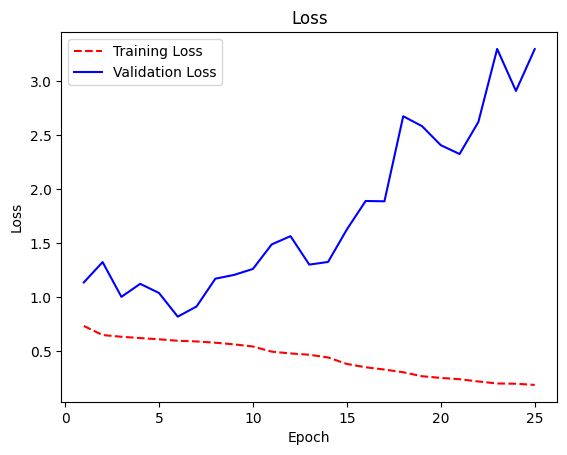

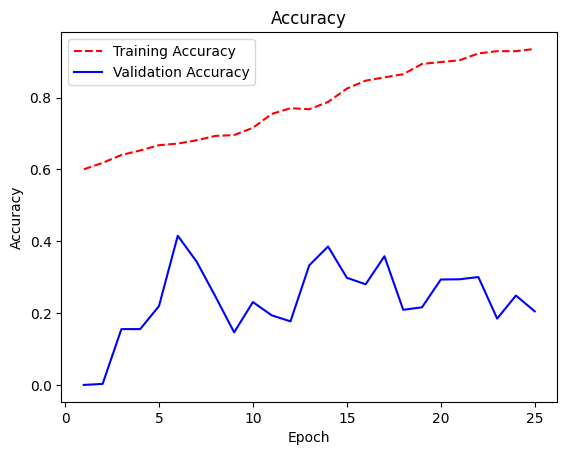

Epoch: 6
loss:0.6
accuracy:0.67
val_loss:0.82
val_accuracy:0.42
lr:0.0
__________ Resnet_50_full __________________________________________________
Epoch 1/25
90/90 [==============================] - 12s 83ms/step - loss: 0.7356 - accuracy: 0.6099 - val_loss: 0.8421 - val_accuracy: 0.2911 - lr: 0.0010
Epoch 2/25
90/90 [==============================] - 4s 45ms/step - loss: 0.6417 - accuracy: 0.6376 - val_loss: 1.2366 - val_accuracy: 0.0132 - lr: 0.0010
Epoch 3/25
90/90 [==============================] - 5s 52ms/step - loss: 0.6246 - accuracy: 0.6517 - val_loss: 0.6661 - val_accuracy: 0.6247 - lr: 0.0010
Epoch 4/25
90/90 [==============================] - 4s 46ms/step - loss: 0.6145 - accuracy: 0.6616 - val_loss: 1.1124 - val_accuracy: 0.1309 - lr: 0.0010
Epoch 5/25
90/90 [==============================] - 4s 45ms/step - loss: 0.6066 - accuracy: 0.6661 - val_loss: 0.8314 - val_accuracy: 0.4889 - lr: 0.0010
Epoch 6/25
90/90 [==============================] - 4s 45ms/step - loss: 0.5968 -

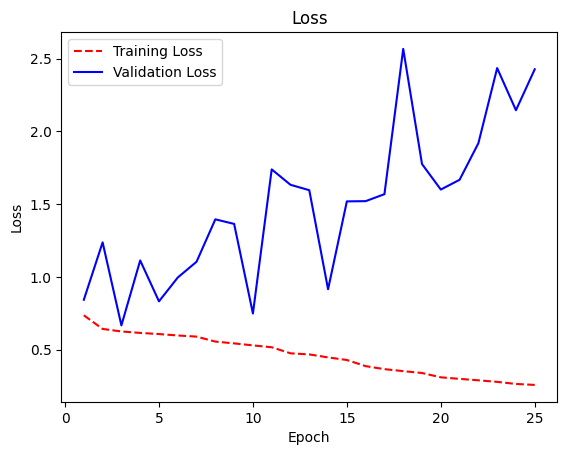

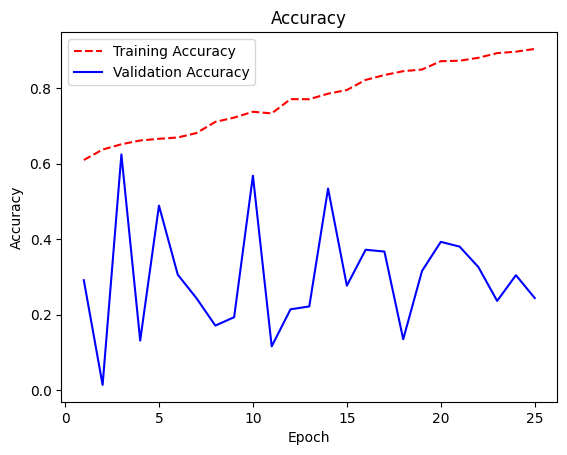

Epoch: 3
loss:0.62
accuracy:0.65
val_loss:0.67
val_accuracy:0.62
lr:0.0
__________ Resnet_152_freeze __________________________________________________
Epoch 1/25
90/90 [==============================] - 21s 139ms/step - loss: 0.7155 - accuracy: 0.7079 - val_loss: 0.9408 - val_accuracy: 0.4596 - lr: 0.0010
Epoch 2/25
90/90 [==============================] - 8s 92ms/step - loss: 0.4299 - accuracy: 0.8130 - val_loss: 0.8157 - val_accuracy: 0.5766 - lr: 0.0010
Epoch 3/25
90/90 [==============================] - 8s 94ms/step - loss: 0.3870 - accuracy: 0.8299 - val_loss: 0.4373 - val_accuracy: 0.7730 - lr: 0.0010
Epoch 4/25
90/90 [==============================] - 7s 77ms/step - loss: 0.3479 - accuracy: 0.8459 - val_loss: 0.6472 - val_accuracy: 0.6790 - lr: 0.0010
Epoch 5/25
90/90 [==============================] - 7s 77ms/step - loss: 0.3099 - accuracy: 0.8669 - val_loss: 0.6500 - val_accuracy: 0.6783 - lr: 0.0010
Epoch 6/25
90/90 [==============================] - 7s 76ms/step - loss: 0.2

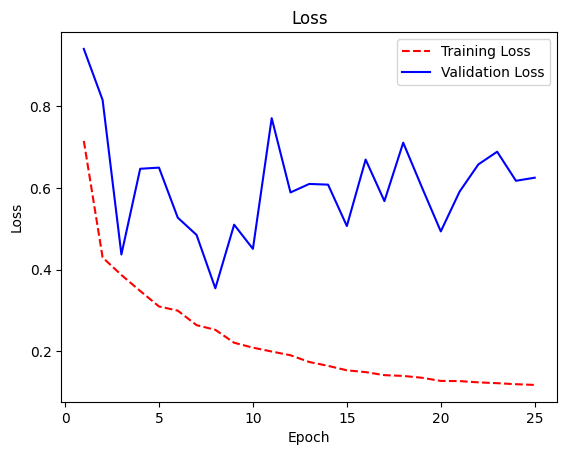

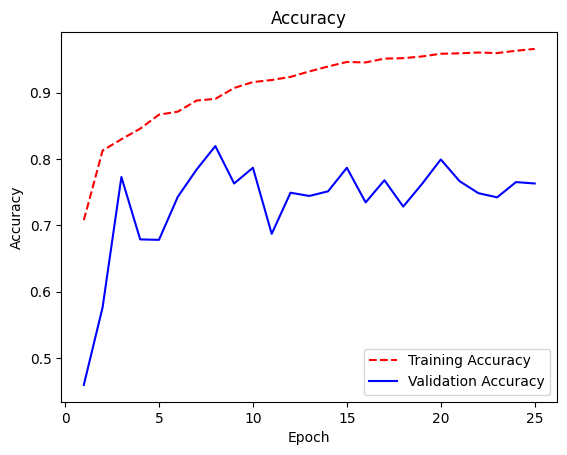

Epoch: 8
loss:0.25
accuracy:0.89
val_loss:0.35
val_accuracy:0.82
lr:0.0
__________ Resnet_101_freeze __________________________________________________
Epoch 1/25
90/90 [==============================] - 16s 108ms/step - loss: 0.7037 - accuracy: 0.5972 - val_loss: 1.2022 - val_accuracy: 0.0014 - lr: 0.0010
Epoch 2/25
90/90 [==============================] - 6s 69ms/step - loss: 0.6599 - accuracy: 0.6156 - val_loss: 0.7443 - val_accuracy: 0.4471 - lr: 0.0010
Epoch 3/25
90/90 [==============================] - 5s 59ms/step - loss: 0.6418 - accuracy: 0.6306 - val_loss: 0.7825 - val_accuracy: 0.4171 - lr: 0.0010
Epoch 4/25
90/90 [==============================] - 5s 58ms/step - loss: 0.6382 - accuracy: 0.6311 - val_loss: 1.0669 - val_accuracy: 0.0808 - lr: 0.0010
Epoch 5/25
90/90 [==============================] - 5s 58ms/step - loss: 0.6333 - accuracy: 0.6371 - val_loss: 0.8368 - val_accuracy: 0.3106 - lr: 0.0010
Epoch 6/25
90/90 [==============================] - 6s 68ms/step - loss: 0.6

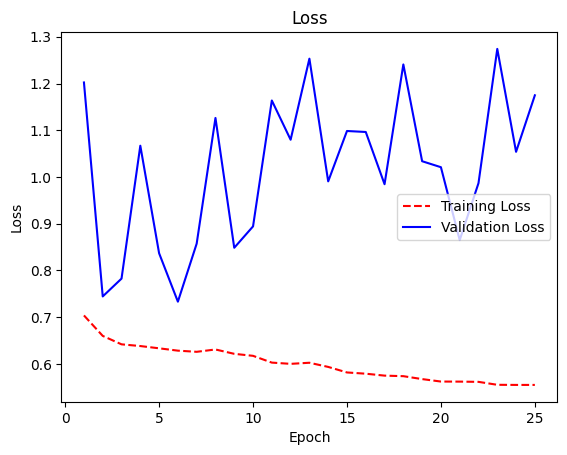

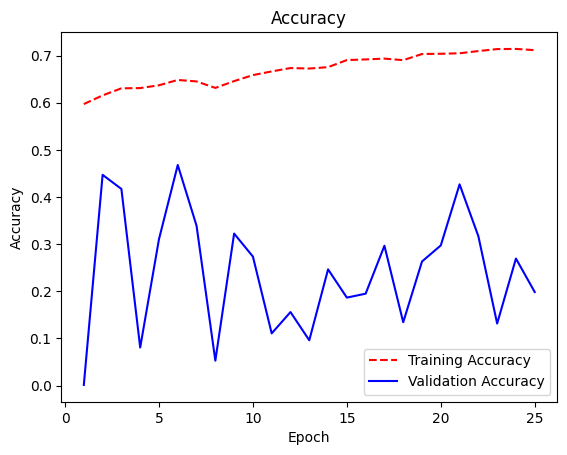

Epoch: 6
loss:0.63
accuracy:0.65
val_loss:0.73
val_accuracy:0.47
lr:0.0
__________ Resnet_50_freeze __________________________________________________
Epoch 1/25
90/90 [==============================] - 10s 77ms/step - loss: 0.7345 - accuracy: 0.5940 - val_loss: 1.0693 - val_accuracy: 0.0341 - lr: 0.0010
Epoch 2/25
90/90 [==============================] - 4s 49ms/step - loss: 0.6525 - accuracy: 0.6278 - val_loss: 0.7647 - val_accuracy: 0.4143 - lr: 0.0010
Epoch 3/25
90/90 [==============================] - 4s 43ms/step - loss: 0.6374 - accuracy: 0.6374 - val_loss: 0.7982 - val_accuracy: 0.3900 - lr: 0.0010
Epoch 4/25
90/90 [==============================] - 4s 44ms/step - loss: 0.6339 - accuracy: 0.6357 - val_loss: 1.1372 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 5/25
90/90 [==============================] - 4s 49ms/step - loss: 0.6282 - accuracy: 0.6465 - val_loss: 0.7534 - val_accuracy: 0.4533 - lr: 0.0010
Epoch 6/25
90/90 [==============================] - 4s 50ms/step - loss: 0.625

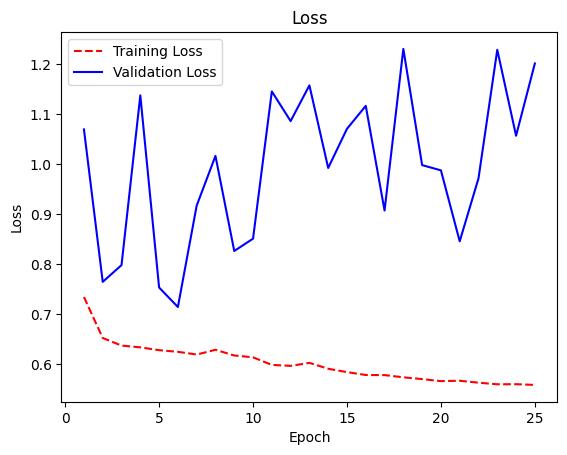

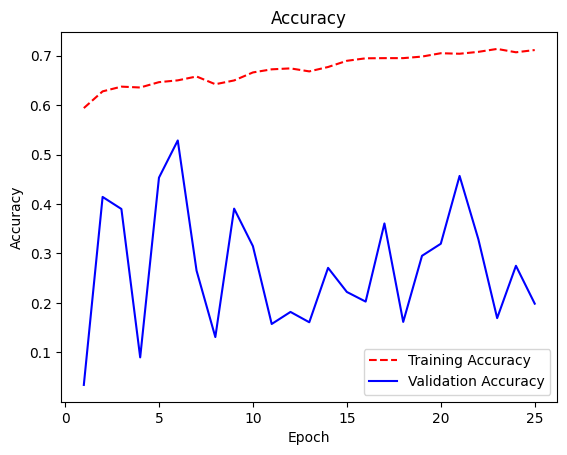

Epoch: 6
loss:0.62
accuracy:0.65
val_loss:0.71
val_accuracy:0.53
lr:0.0
__________ VGG_16_full __________________________________________________
Epoch 1/25
90/90 [==============================] - 11s 88ms/step - loss: 0.5326 - accuracy: 0.7276 - val_loss: 0.4608 - val_accuracy: 0.7660 - lr: 0.0010
Epoch 2/25
90/90 [==============================] - 4s 46ms/step - loss: 0.3119 - accuracy: 0.8706 - val_loss: 0.5233 - val_accuracy: 0.7354 - lr: 0.0010
Epoch 3/25
90/90 [==============================] - 4s 48ms/step - loss: 0.2310 - accuracy: 0.9047 - val_loss: 0.3434 - val_accuracy: 0.8496 - lr: 0.0010
Epoch 4/25
90/90 [==============================] - 4s 47ms/step - loss: 0.2244 - accuracy: 0.9084 - val_loss: 0.5971 - val_accuracy: 0.7249 - lr: 0.0010
Epoch 5/25
90/90 [==============================] - 4s 48ms/step - loss: 0.1674 - accuracy: 0.9361 - val_loss: 0.1781 - val_accuracy: 0.9276 - lr: 0.0010
Epoch 6/25
90/90 [==============================] - 4s 49ms/step - loss: 0.1380 - a

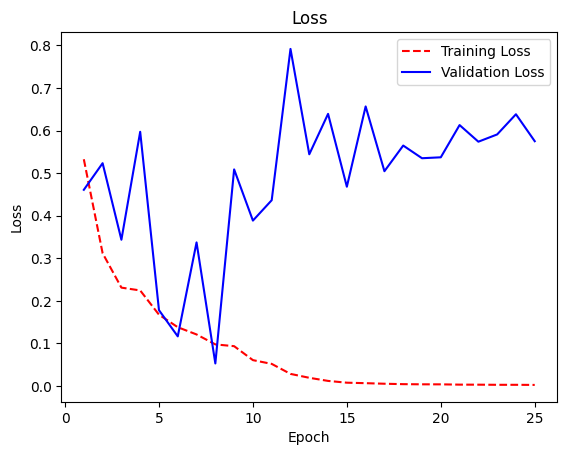

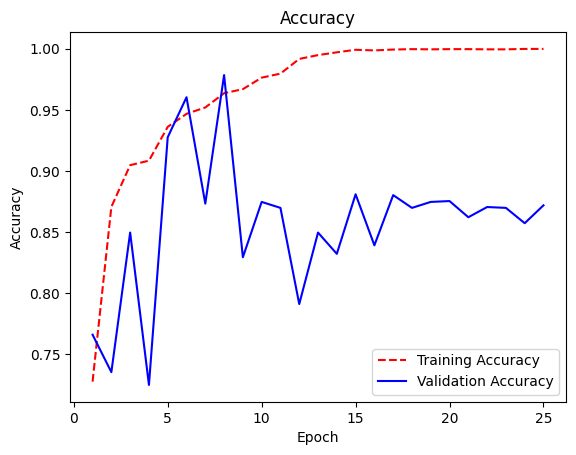

Epoch: 8
loss:0.1
accuracy:0.96
val_loss:0.05
val_accuracy:0.98
lr:0.0
__________ VGG_19_full __________________________________________________
Epoch 1/25
90/90 [==============================] - 9s 79ms/step - loss: 0.5114 - accuracy: 0.7571 - val_loss: 0.5743 - val_accuracy: 0.7284 - lr: 0.0010
Epoch 2/25
90/90 [==============================] - 5s 55ms/step - loss: 0.3013 - accuracy: 0.8737 - val_loss: 0.3521 - val_accuracy: 0.8593 - lr: 0.0010
Epoch 3/25
90/90 [==============================] - 5s 55ms/step - loss: 0.2117 - accuracy: 0.9150 - val_loss: 0.3264 - val_accuracy: 0.8691 - lr: 0.0010
Epoch 4/25
90/90 [==============================] - 5s 55ms/step - loss: 0.1820 - accuracy: 0.9284 - val_loss: 0.2734 - val_accuracy: 0.8858 - lr: 0.0010
Epoch 5/25
90/90 [==============================] - 5s 53ms/step - loss: 0.1792 - accuracy: 0.9302 - val_loss: 0.4056 - val_accuracy: 0.8329 - lr: 0.0010
Epoch 6/25
90/90 [==============================] - 5s 55ms/step - loss: 0.1713 - acc

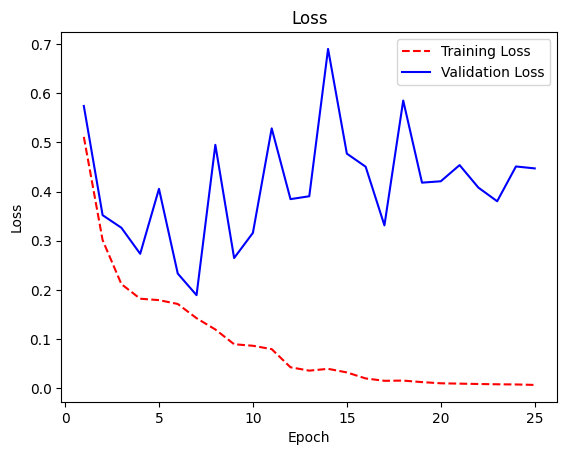

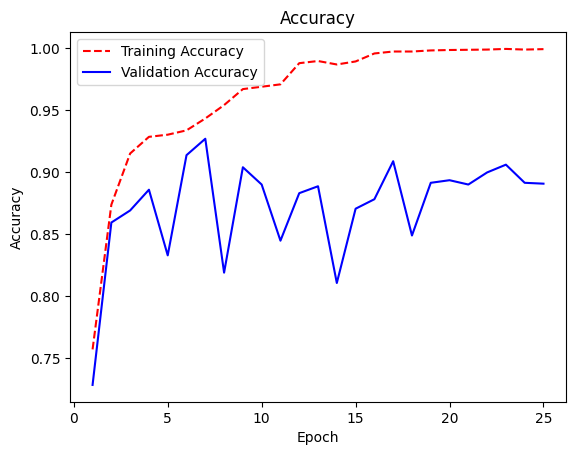

Epoch: 7
loss:0.14
accuracy:0.94
val_loss:0.19
val_accuracy:0.93
lr:0.0
__________ VGG_16_freeze __________________________________________________
Epoch 1/25
90/90 [==============================] - 8s 80ms/step - loss: 0.6510 - accuracy: 0.6184 - val_loss: 0.9695 - val_accuracy: 0.1058 - lr: 0.0010
Epoch 2/25
90/90 [==============================] - 5s 57ms/step - loss: 0.6109 - accuracy: 0.6728 - val_loss: 0.7796 - val_accuracy: 0.3788 - lr: 0.0010
Epoch 3/25
90/90 [==============================] - 5s 57ms/step - loss: 0.5878 - accuracy: 0.6959 - val_loss: 0.6271 - val_accuracy: 0.6393 - lr: 0.0010
Epoch 4/25
90/90 [==============================] - 5s 55ms/step - loss: 0.5772 - accuracy: 0.7011 - val_loss: 0.8692 - val_accuracy: 0.3642 - lr: 0.0010
Epoch 5/25
90/90 [==============================] - 5s 55ms/step - loss: 0.5586 - accuracy: 0.7198 - val_loss: 0.6962 - val_accuracy: 0.5752 - lr: 0.0010
Epoch 6/25
90/90 [==============================] - 5s 58ms/step - loss: 0.5544 - 

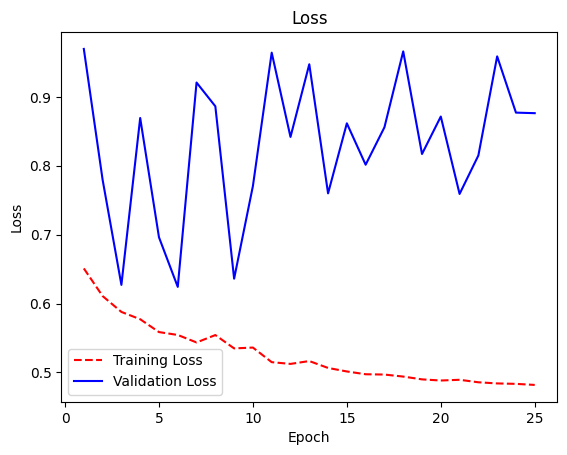

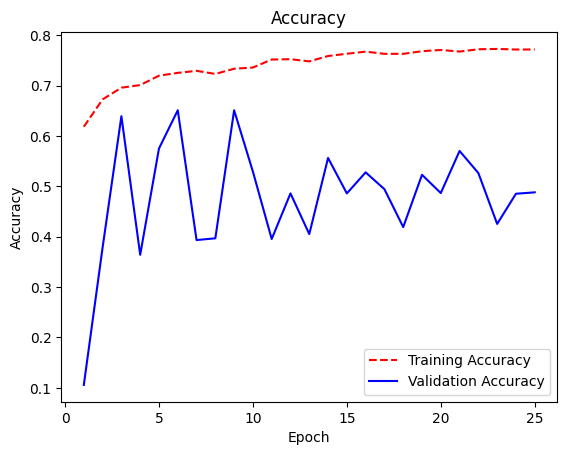

Epoch: 6
loss:0.55
accuracy:0.73
val_loss:0.62
val_accuracy:0.65
lr:0.0
__________ VGG_19_freeze __________________________________________________
Epoch 1/25
90/90 [==============================] - 9s 88ms/step - loss: 0.6494 - accuracy: 0.6240 - val_loss: 0.9067 - val_accuracy: 0.1734 - lr: 0.0010
Epoch 2/25
90/90 [==============================] - 6s 65ms/step - loss: 0.6058 - accuracy: 0.6691 - val_loss: 0.7463 - val_accuracy: 0.4610 - lr: 0.0010
Epoch 3/25
90/90 [==============================] - 6s 64ms/step - loss: 0.5796 - accuracy: 0.6987 - val_loss: 0.5979 - val_accuracy: 0.6762 - lr: 0.0010
Epoch 4/25
90/90 [==============================] - 6s 62ms/step - loss: 0.5664 - accuracy: 0.7083 - val_loss: 0.8795 - val_accuracy: 0.3851 - lr: 0.0010
Epoch 5/25
90/90 [==============================] - 6s 62ms/step - loss: 0.5544 - accuracy: 0.7189 - val_loss: 0.7652 - val_accuracy: 0.5118 - lr: 0.0010
Epoch 6/25
90/90 [==============================] - 6s 61ms/step - loss: 0.5463 - 

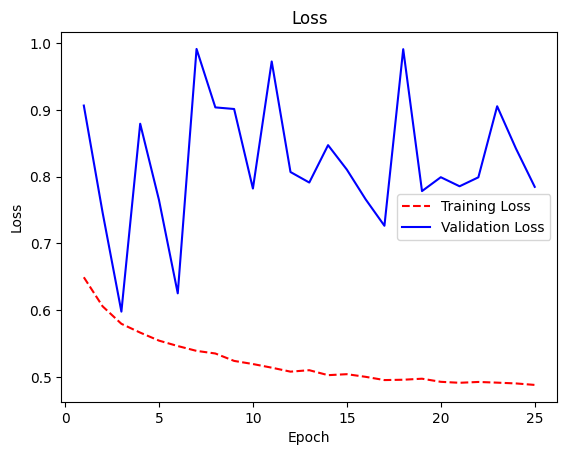

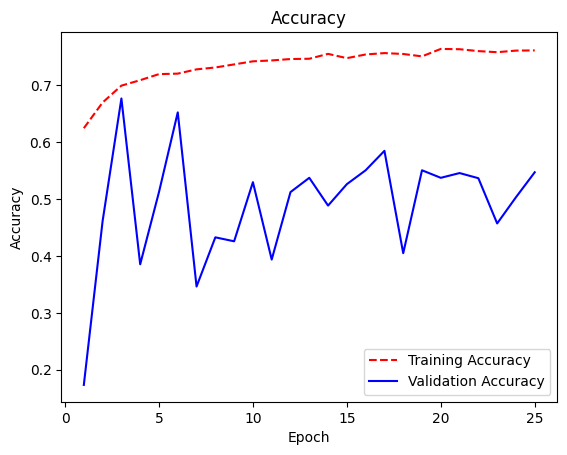

Epoch: 3
loss:0.58
accuracy:0.7
val_loss:0.6
val_accuracy:0.68
lr:0.0


In [ ]:
for key in model_softmax.keys():
  print("_"*10, key, "_"*50)
  model_softmax[key] = Model(model_softmax[key], 0.001, f'/content/drive/MyDrive/final_model/checkpoint_sigmoid/{key}', "binary_crossentropy")
  model_softmax[key].train(model_data[key].images, model_data[key].labels, batch_size=64, epoch=25, validation_split=0.2)
  tf.keras.backend.clear_session()

## Elm Training

In [ ]:
for key in model_softmax.keys():
  for layer in model_softmax[key].model.layers:
      layer.trainable = False
  model_softmax[key].remove_layer(2)

In [ ]:
def batch_predict(model, images, batch=32):
  array1 = []
  for idx in range(0, len(images), batch):
    array2 = model.predict(images[idx: min(len(images), idx+batch)], verbose=0)
    if len(array1)>0:
      array1 = np.concatenate((array1, array2), axis=0)
    else:
      array1 = array2
  return array1

In [ ]:
model_elm = {}
for key in model_softmax.keys():
  print("_"*10, key, "_"*10)
  Xtrain = batch_predict(model_softmax[key].headless_model, model_data[key].images, 64)
  Ytrain = model_data[key].labels

  model_elm[key] = elm(hidden_units=16, activation_function='relu', random_type='normal', x=Xtrain, y=Ytrain, C=0.1, elm_type='clf')
  beta, train_accuracy, running_time = model_elm[key].fit('solution2')
  print("classifier train accuracy:", train_accuracy)
  print('classifier running time:', running_time)

__________ Resnet_152_full __________
classifier train accuracy: 0.914182223460574
classifier running time: 0.03447222709655762
__________ Resnet_101_full __________
classifier train accuracy: 0.6324881582613542
classifier running time: 0.02266836166381836
__________ Resnet_50_full __________
classifier train accuracy: 0.6000278629144609
classifier running time: 0.027547836303710938
__________ Resnet_152_freeze __________
classifier train accuracy: 0.8367233212594037
classifier running time: 0.022869348526000977
__________ Resnet_101_freeze __________
classifier train accuracy: 0.5979381443298969
classifier running time: 0.022485017776489258
__________ Resnet_50_freeze __________
classifier train accuracy: 0.6018389523544163
classifier running time: 0.02347278594970703
__________ VGG_16_full __________
classifier train accuracy: 0.9455280022290331
classifier running time: 0.02247452735900879
__________ VGG_19_full __________
classifier train accuracy: 0.9605739760378935
classifier runn

## Svm Training

In [ ]:
model_svm = {}
for key in model_softmax.keys():
  print("_"*10, key, "_"*10)
  #with tf.device('/CPU:0'):
  Xtrain = batch_predict(model_softmax[key].headless_model, model_data[key].images, 64)
  Ytrain = model_data[key].labels
  model_svm[key] = make_pipeline(SVC())
  model_svm[key].fit(Xtrain, Ytrain)
  print("Classifier train accuracy:", model_svm[key].score(Xtrain, Ytrain))

__________ Resnet_152_full __________
Classifier train accuracy: 0.9432989690721649
__________ Resnet_101_full __________
Classifier train accuracy: 0.6730286988018946
__________ Resnet_50_full __________
Classifier train accuracy: 0.64084703259961
__________ Resnet_152_freeze __________
Classifier train accuracy: 0.910002786291446
__________ Resnet_101_freeze __________
Classifier train accuracy: 0.6405684034550014
__________ Resnet_50_freeze __________
Classifier train accuracy: 0.6412649763165227
__________ VGG_16_full __________
Classifier train accuracy: 0.9665645026469769
__________ VGG_19_full __________
Classifier train accuracy: 0.9621064363332404
__________ VGG_16_freeze __________
Classifier train accuracy: 0.7294511005851212
__________ VGG_19_freeze __________
Classifier train accuracy: 0.7191418222346058


In [ ]:
#dump training data
training_dataset = None
training_dataset_152_layer = None
model_data = None

## Load Test Data

In [ ]:
# test Data
image_loc_ground = glob.glob(test_gt+"/*.jpg")
label_ground = len(image_loc_ground) * ["ground"]

image_loc_gen = glob.glob(test_gen+"/*.jpg")
label_gen = len(image_loc_gen) * ["recon"]

image_loc_ec = glob.glob(test_ec+"/*.jpg")
label_ec = len(image_loc_ec) * ["recon"]

image_loc_vqvae = glob.glob(test_vqvae+"/*.jpg")
label_vqvae = len(image_loc_vqvae) * ["recon"]

test_dataset = {
    "gen": DatasetCreation(
        image_loc_ground+image_loc_gen,
        label_ground+label_gen,
        "binary"
        ),
    "ec": DatasetCreation(
        image_loc_ground+image_loc_ec,
        label_ground+label_ec,
        "binary"
        ),
    "vqvae": DatasetCreation(
        image_loc_ground+image_loc_vqvae,
        label_ground+label_vqvae,
        "binary"
        ),
}

test_dataset_152_layer = {
    "gen": DatasetCreation(
        image_loc_ground+image_loc_gen,
        label_ground+label_gen,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
    "ec": DatasetCreation(
        image_loc_ground+image_loc_ec,
        label_ground+label_ec,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
    "vqvae": DatasetCreation(
        image_loc_ground+image_loc_vqvae,
        label_ground+label_vqvae,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
}
model_data = {
    "Resnet_152_full": test_dataset_152_layer,
    "Resnet_101_full": test_dataset,
    "Resnet_50_full": test_dataset,
    "Resnet_152_freeze": test_dataset_152_layer,
    "Resnet_101_freeze": test_dataset,
    "Resnet_50_freeze": test_dataset,
    "VGG_16_full": test_dataset,
    "VGG_19_full": test_dataset,
    "VGG_16_freeze": test_dataset,
    "VGG_19_freeze": test_dataset,
}

_________Loading Images__________


100%|██████████| 1000/1000 [00:05<00:00, 192.61it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:04<00:00, 202.13it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:04<00:00, 204.33it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:03<00:00, 276.17it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:03<00:00, 298.11it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:03<00:00, 276.55it/s]


## Testing



 __________________________________________________ Resnet_152_full __________________________________________________

__________gen__________
Accuracy 0.786
Precision: 0.766000
Recall: 0.797917
F1 score: 0.781633
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       500
           1       0.80      0.77      0.78       500

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000



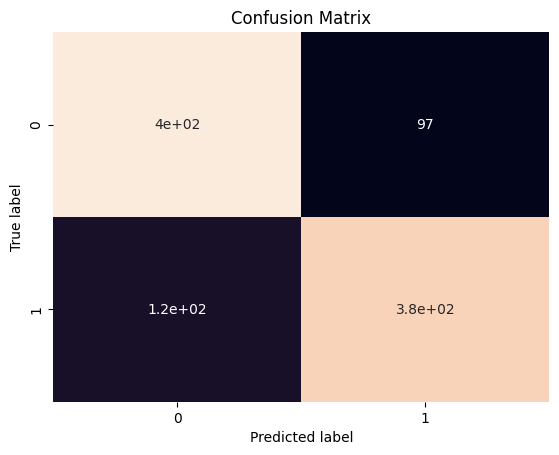

__________ec__________
Accuracy 0.899
Precision: 0.992000
Recall: 0.836425
F1 score: 0.907594
              precision    recall  f1-score   support

           0       0.99      0.81      0.89       500
           1       0.84      0.99      0.91       500

    accuracy                           0.90      1000
   macro avg       0.91      0.90      0.90      1000
weighted avg       0.91      0.90      0.90      1000



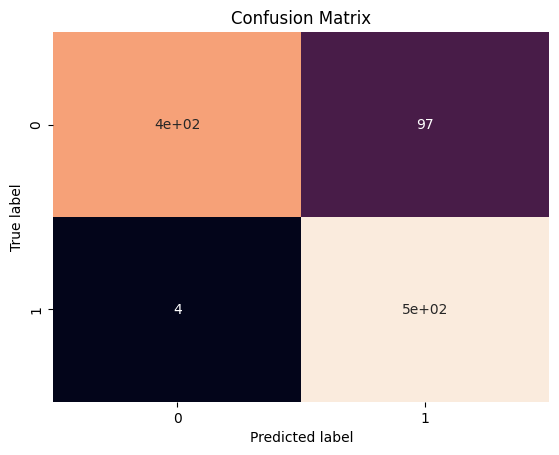

__________vqvae__________
Accuracy 0.884
Precision: 0.962000
Recall: 0.832180
F1 score: 0.892393
              precision    recall  f1-score   support

           0       0.95      0.81      0.87       500
           1       0.83      0.96      0.89       500

    accuracy                           0.88      1000
   macro avg       0.89      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000



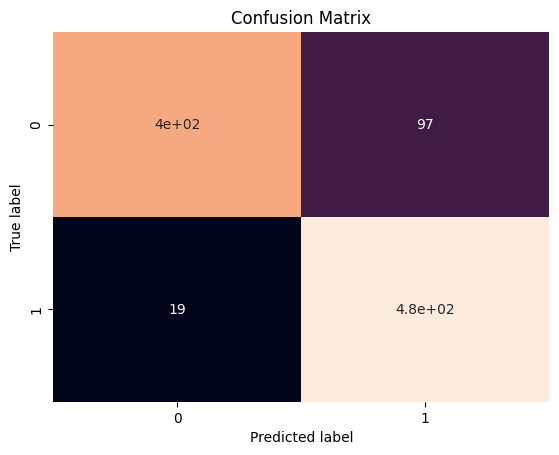



 __________________________________________________ Resnet_101_full __________________________________________________

__________gen__________
Accuracy 0.555
Precision: 0.432000
Recall: 0.572944
F1 score: 0.492588
              precision    recall  f1-score   support

           0       0.54      0.68      0.60       500
           1       0.57      0.43      0.49       500

    accuracy                           0.56      1000
   macro avg       0.56      0.56      0.55      1000
weighted avg       0.56      0.56      0.55      1000



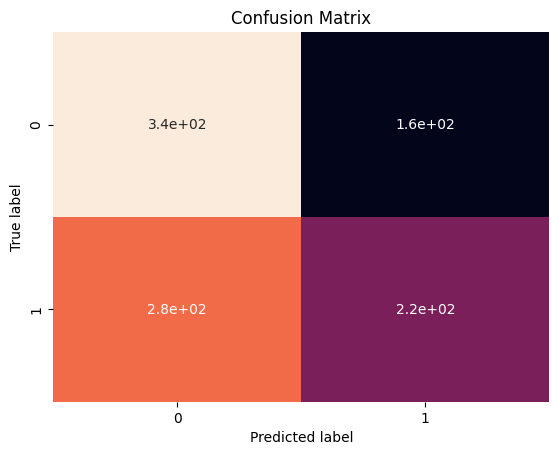

__________ec__________
Accuracy 0.684
Precision: 0.690000
Recall: 0.681818
F1 score: 0.685885
              precision    recall  f1-score   support

           0       0.69      0.68      0.68       500
           1       0.68      0.69      0.69       500

    accuracy                           0.68      1000
   macro avg       0.68      0.68      0.68      1000
weighted avg       0.68      0.68      0.68      1000



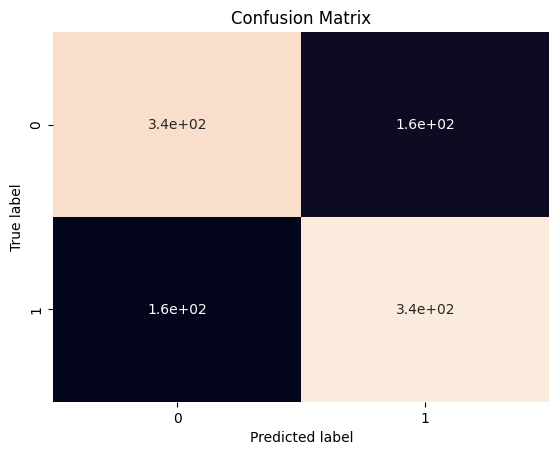

__________vqvae__________
Accuracy 0.524
Precision: 0.370000
Recall: 0.534682
F1 score: 0.437352
              precision    recall  f1-score   support

           0       0.52      0.68      0.59       500
           1       0.53      0.37      0.44       500

    accuracy                           0.52      1000
   macro avg       0.53      0.52      0.51      1000
weighted avg       0.53      0.52      0.51      1000



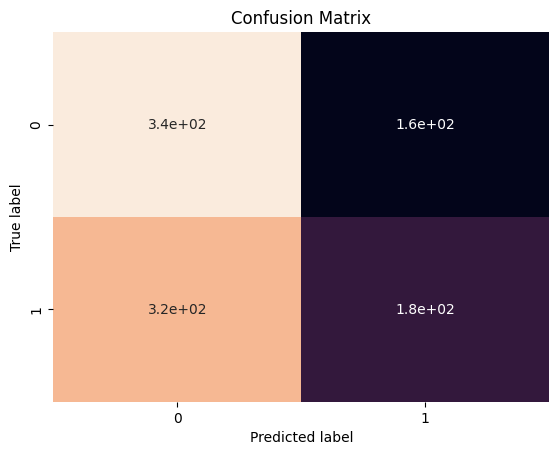



 __________________________________________________ Resnet_50_full __________________________________________________

__________gen__________
Accuracy 0.568
Precision: 0.554000
Recall: 0.569959
F1 score: 0.561866
              precision    recall  f1-score   support

           0       0.57      0.58      0.57       500
           1       0.57      0.55      0.56       500

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.57      1000
weighted avg       0.57      0.57      0.57      1000



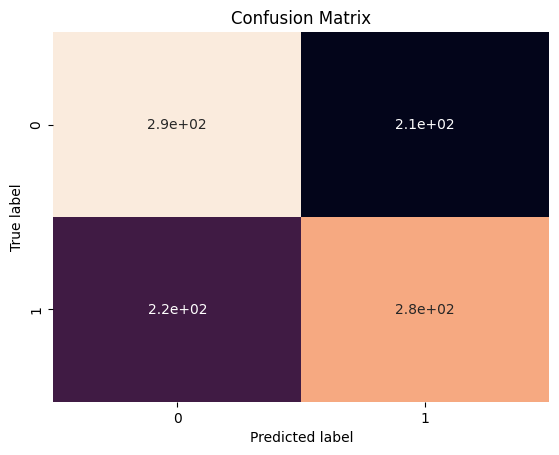

__________ec__________
Accuracy 0.672
Precision: 0.762000
Recall: 0.645763
F1 score: 0.699083
              precision    recall  f1-score   support

           0       0.71      0.58      0.64       500
           1       0.65      0.76      0.70       500

    accuracy                           0.67      1000
   macro avg       0.68      0.67      0.67      1000
weighted avg       0.68      0.67      0.67      1000



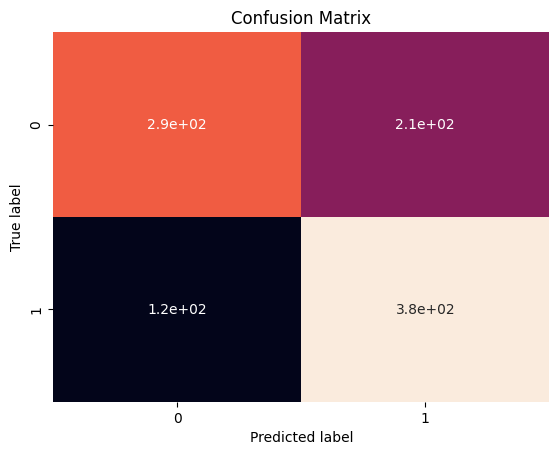

__________vqvae__________
Accuracy 0.557
Precision: 0.532000
Recall: 0.560000
F1 score: 0.545641
              precision    recall  f1-score   support

           0       0.55      0.58      0.57       500
           1       0.56      0.53      0.55       500

    accuracy                           0.56      1000
   macro avg       0.56      0.56      0.56      1000
weighted avg       0.56      0.56      0.56      1000



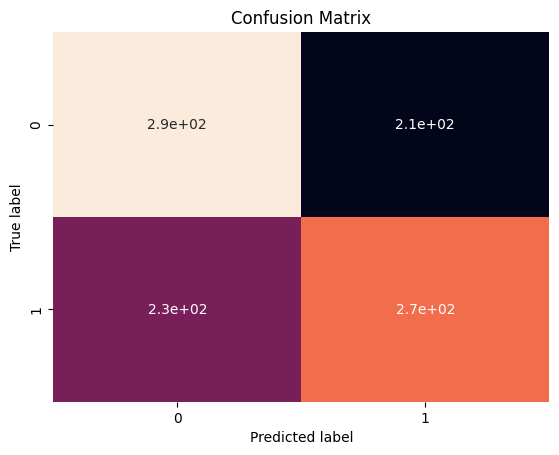



 __________________________________________________ Resnet_152_freeze __________________________________________________

__________gen__________
Accuracy 0.764
Precision: 0.750000
Recall: 0.771605
F1 score: 0.760649
              precision    recall  f1-score   support

           0       0.76      0.78      0.77       500
           1       0.77      0.75      0.76       500

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000



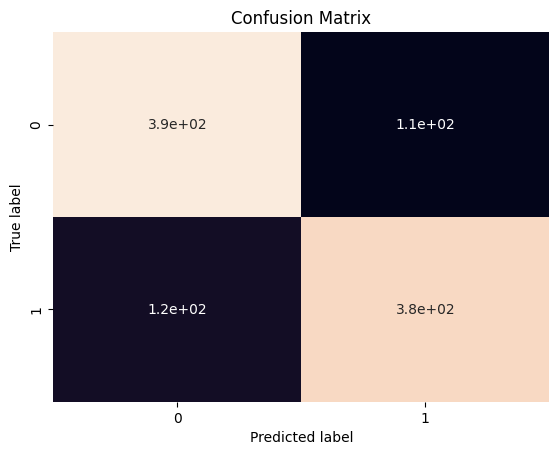

__________ec__________
Accuracy 0.887
Precision: 0.996000
Recall: 0.817734
F1 score: 0.898106
              precision    recall  f1-score   support

           0       0.99      0.78      0.87       500
           1       0.82      1.00      0.90       500

    accuracy                           0.89      1000
   macro avg       0.91      0.89      0.89      1000
weighted avg       0.91      0.89      0.89      1000



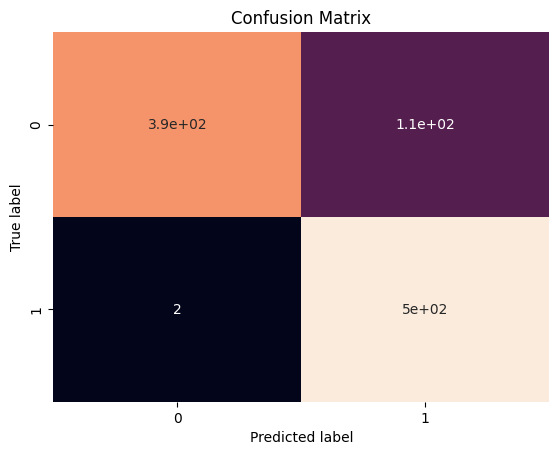

__________vqvae__________
Accuracy 0.869
Precision: 0.960000
Recall: 0.812183
F1 score: 0.879927
              precision    recall  f1-score   support

           0       0.95      0.78      0.86       500
           1       0.81      0.96      0.88       500

    accuracy                           0.87      1000
   macro avg       0.88      0.87      0.87      1000
weighted avg       0.88      0.87      0.87      1000



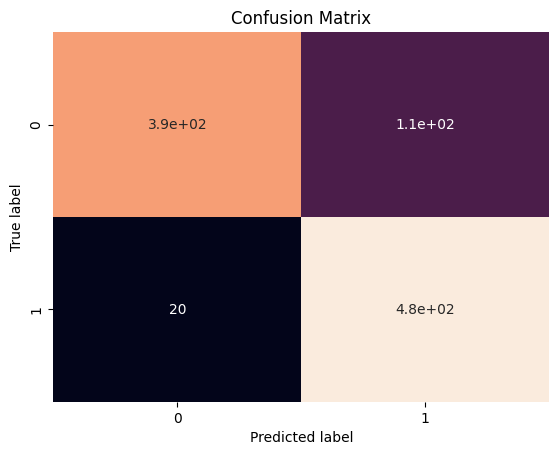



 __________________________________________________ Resnet_101_freeze __________________________________________________

__________gen__________
Accuracy 0.554
Precision: 0.468000
Recall: 0.565217
F1 score: 0.512035
              precision    recall  f1-score   support

           0       0.55      0.64      0.59       500
           1       0.57      0.47      0.51       500

    accuracy                           0.55      1000
   macro avg       0.56      0.55      0.55      1000
weighted avg       0.56      0.55      0.55      1000



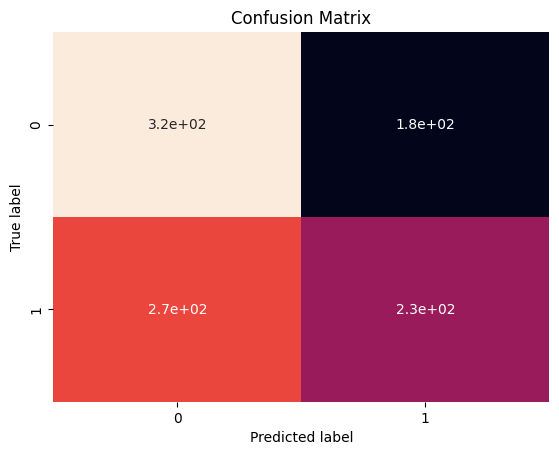

__________ec__________
Accuracy 0.666
Precision: 0.692000
Recall: 0.657795
F1 score: 0.674464
              precision    recall  f1-score   support

           0       0.68      0.64      0.66       500
           1       0.66      0.69      0.67       500

    accuracy                           0.67      1000
   macro avg       0.67      0.67      0.67      1000
weighted avg       0.67      0.67      0.67      1000



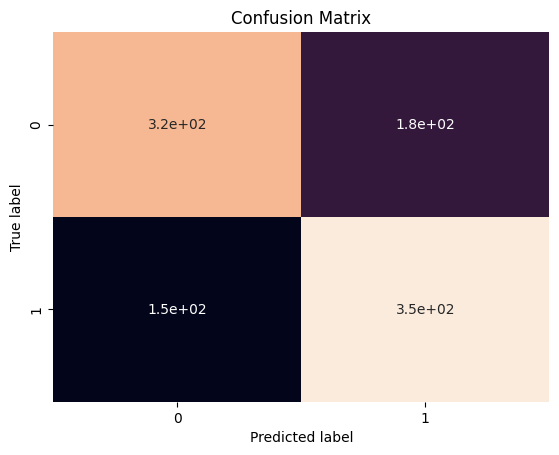

__________vqvae__________
Accuracy 0.525
Precision: 0.410000
Recall: 0.532468
F1 score: 0.463277
              precision    recall  f1-score   support

           0       0.52      0.64      0.57       500
           1       0.53      0.41      0.46       500

    accuracy                           0.53      1000
   macro avg       0.53      0.53      0.52      1000
weighted avg       0.53      0.53      0.52      1000



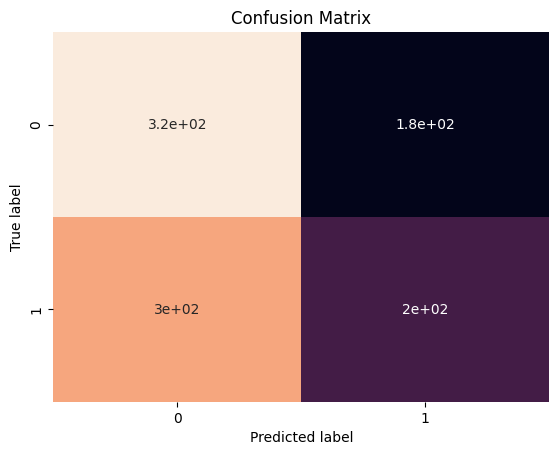



 __________________________________________________ Resnet_50_freeze __________________________________________________

__________gen__________
Accuracy 0.58
Precision: 0.510000
Recall: 0.593023
F1 score: 0.548387
              precision    recall  f1-score   support

           0       0.57      0.65      0.61       500
           1       0.59      0.51      0.55       500

    accuracy                           0.58      1000
   macro avg       0.58      0.58      0.58      1000
weighted avg       0.58      0.58      0.58      1000



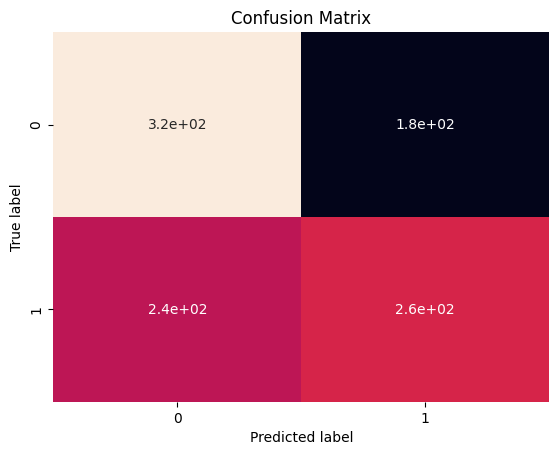

__________ec__________
Accuracy 0.715
Precision: 0.780000
Recall: 0.690265
F1 score: 0.732394
              precision    recall  f1-score   support

           0       0.75      0.65      0.70       500
           1       0.69      0.78      0.73       500

    accuracy                           0.71      1000
   macro avg       0.72      0.72      0.71      1000
weighted avg       0.72      0.71      0.71      1000



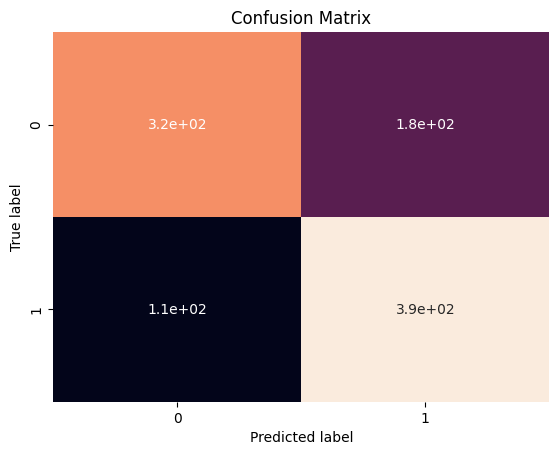

__________vqvae__________
Accuracy 0.559
Precision: 0.468000
Recall: 0.572127
F1 score: 0.514851
              precision    recall  f1-score   support

           0       0.55      0.65      0.60       500
           1       0.57      0.47      0.51       500

    accuracy                           0.56      1000
   macro avg       0.56      0.56      0.56      1000
weighted avg       0.56      0.56      0.56      1000



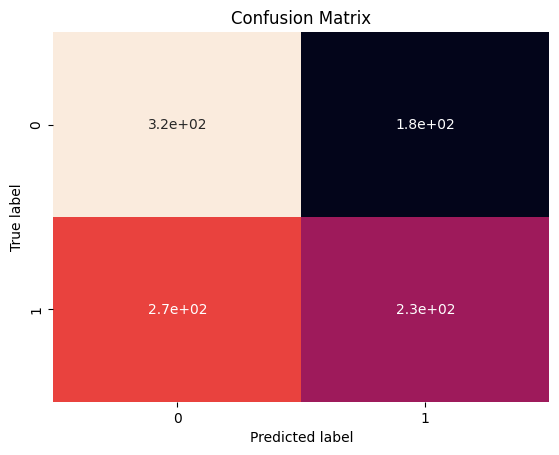



 __________________________________________________ VGG_16_full __________________________________________________

__________gen__________
Accuracy 0.852
Precision: 0.962000
Recall: 0.788525
F1 score: 0.866667
              precision    recall  f1-score   support

           0       0.95      0.74      0.83       500
           1       0.79      0.96      0.87       500

    accuracy                           0.85      1000
   macro avg       0.87      0.85      0.85      1000
weighted avg       0.87      0.85      0.85      1000



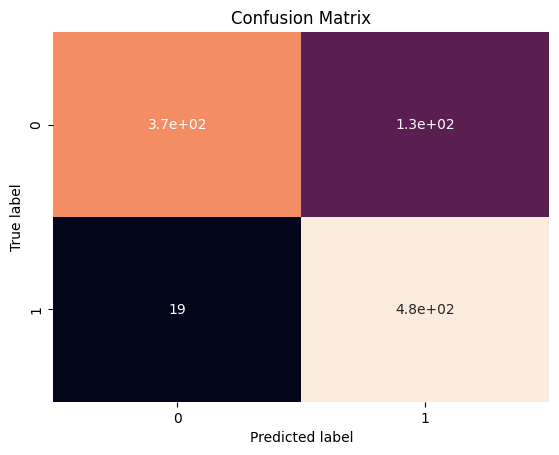

__________ec__________
Accuracy 0.87
Precision: 0.998000
Recall: 0.794586
F1 score: 0.884752
              precision    recall  f1-score   support

           0       1.00      0.74      0.85       500
           1       0.79      1.00      0.88       500

    accuracy                           0.87      1000
   macro avg       0.90      0.87      0.87      1000
weighted avg       0.90      0.87      0.87      1000



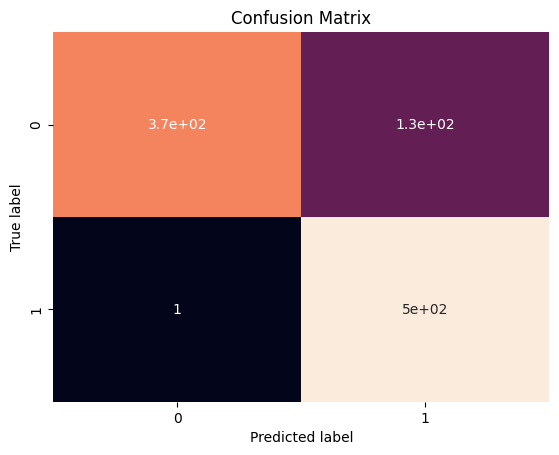

__________vqvae__________
Accuracy 0.868
Precision: 0.994000
Recall: 0.793930
F1 score: 0.882771
              precision    recall  f1-score   support

           0       0.99      0.74      0.85       500
           1       0.79      0.99      0.88       500

    accuracy                           0.87      1000
   macro avg       0.89      0.87      0.87      1000
weighted avg       0.89      0.87      0.87      1000



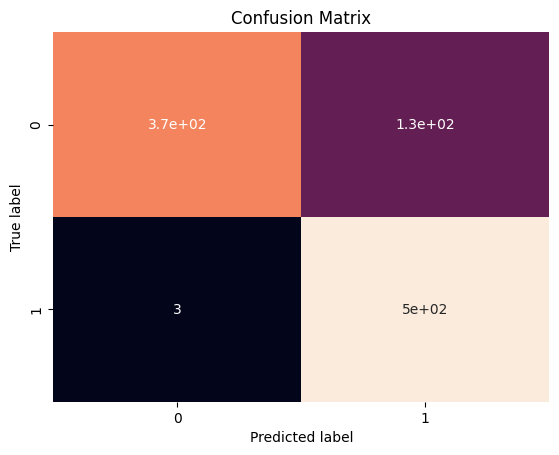



 __________________________________________________ VGG_19_full __________________________________________________

__________gen__________
Accuracy 0.909
Precision: 0.906000
Recall: 0.911469
F1 score: 0.908726
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       500
           1       0.91      0.91      0.91       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



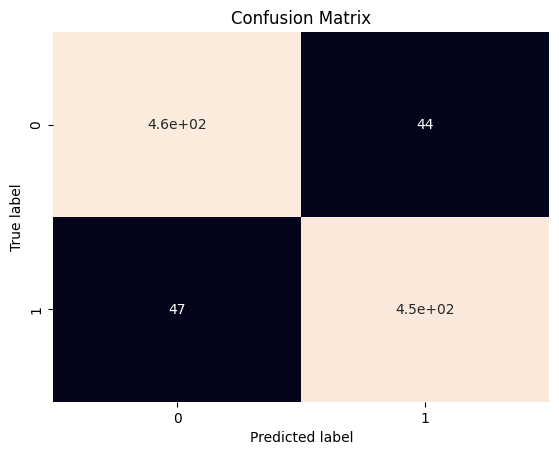

__________ec__________
Accuracy 0.955
Precision: 0.998000
Recall: 0.918969
F1 score: 0.956855
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       500
           1       0.92      1.00      0.96       500

    accuracy                           0.95      1000
   macro avg       0.96      0.96      0.95      1000
weighted avg       0.96      0.95      0.95      1000



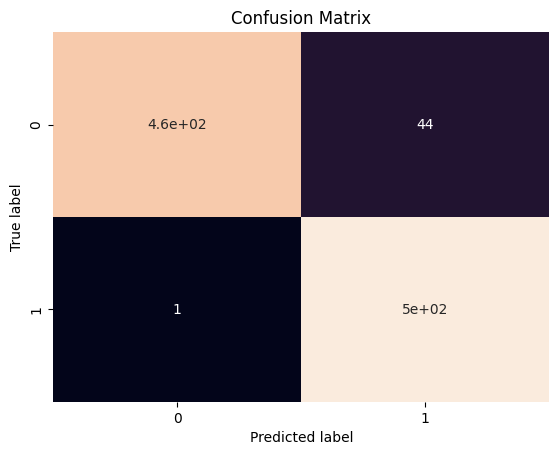

__________vqvae__________
Accuracy 0.937
Precision: 0.962000
Recall: 0.916190
F1 score: 0.938537
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       500
           1       0.92      0.96      0.94       500

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



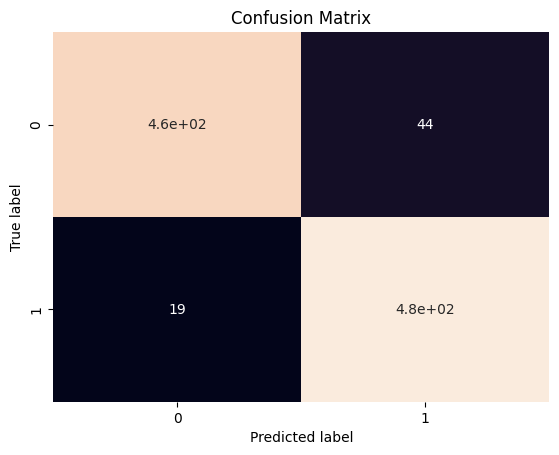



 __________________________________________________ VGG_16_freeze __________________________________________________

__________gen__________
Accuracy 0.592
Precision: 0.484000
Recall: 0.617347
F1 score: 0.542601
              precision    recall  f1-score   support

           0       0.58      0.70      0.63       500
           1       0.62      0.48      0.54       500

    accuracy                           0.59      1000
   macro avg       0.60      0.59      0.59      1000
weighted avg       0.60      0.59      0.59      1000



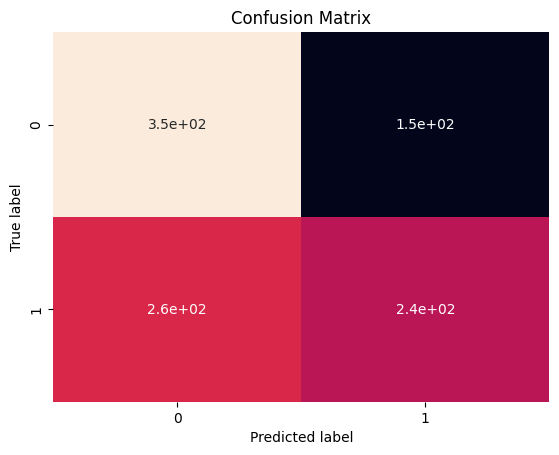

__________ec__________
Accuracy 0.761
Precision: 0.822000
Recall: 0.732620
F1 score: 0.774741
              precision    recall  f1-score   support

           0       0.80      0.70      0.75       500
           1       0.73      0.82      0.77       500

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000



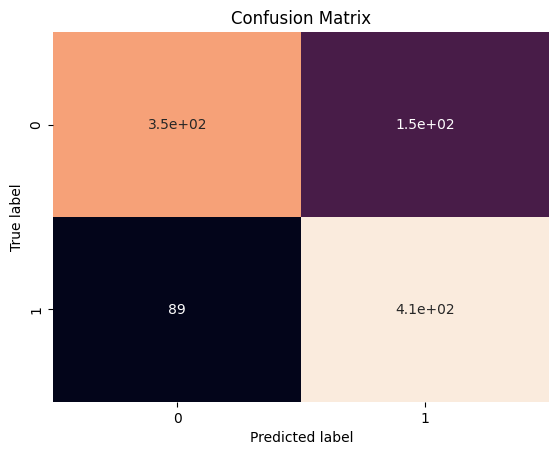

__________vqvae__________
Accuracy 0.757
Precision: 0.814000
Recall: 0.730700
F1 score: 0.770104
              precision    recall  f1-score   support

           0       0.79      0.70      0.74       500
           1       0.73      0.81      0.77       500

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000



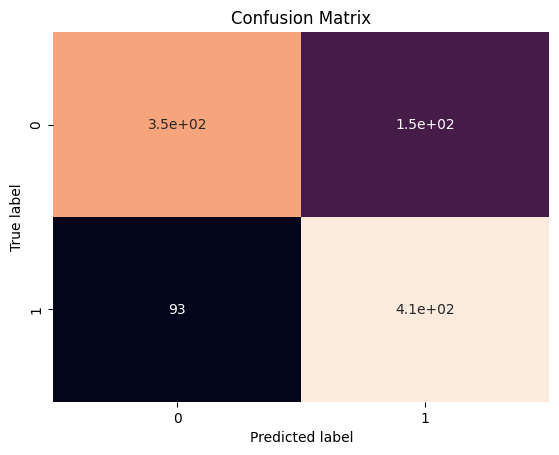



 __________________________________________________ VGG_19_freeze __________________________________________________

__________gen__________
Accuracy 0.593
Precision: 0.498000
Recall: 0.614815
F1 score: 0.550276
              precision    recall  f1-score   support

           0       0.58      0.69      0.63       500
           1       0.61      0.50      0.55       500

    accuracy                           0.59      1000
   macro avg       0.60      0.59      0.59      1000
weighted avg       0.60      0.59      0.59      1000



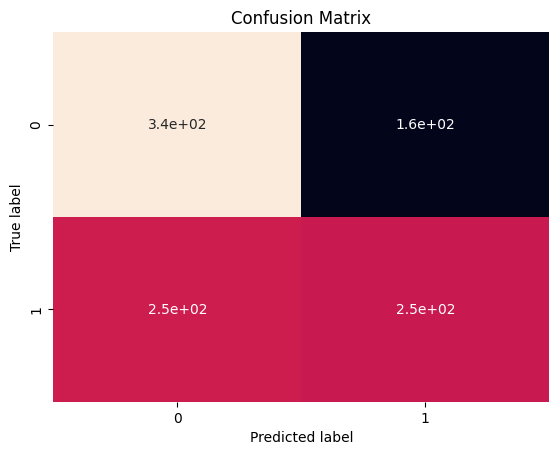

__________ec__________
Accuracy 0.734
Precision: 0.780000
Recall: 0.714286
F1 score: 0.745698
              precision    recall  f1-score   support

           0       0.76      0.69      0.72       500
           1       0.71      0.78      0.75       500

    accuracy                           0.73      1000
   macro avg       0.74      0.73      0.73      1000
weighted avg       0.74      0.73      0.73      1000



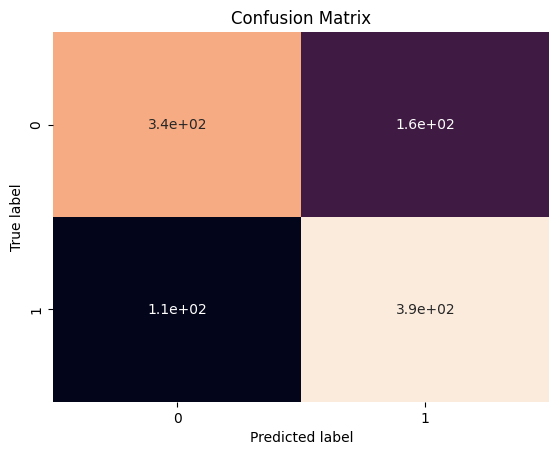

__________vqvae__________
Accuracy 0.735
Precision: 0.782000
Recall: 0.714808
F1 score: 0.746896
              precision    recall  f1-score   support

           0       0.76      0.69      0.72       500
           1       0.71      0.78      0.75       500

    accuracy                           0.73      1000
   macro avg       0.74      0.73      0.73      1000
weighted avg       0.74      0.73      0.73      1000



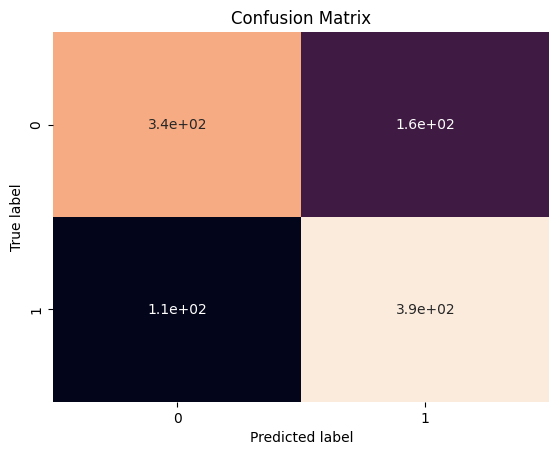

In [ ]:
for model_name in model_softmax.keys():
  print("\n\n","_"*50, model_name, "_"*50, end = "\n\n")

  for key in model_data[model_name].keys():
    y_result = batch_predict(model_softmax[model_name].model, model_data[model_name][key].images, 64)
    y_result = y_result>0.5

    labels = model_data[model_name][key].labels
    print(f"{'_'*10}{key}{'_'*10}")
    print("Accuracy", accuracy_score(y_result, labels))

    # precision tp / (tp + fp)
    precision = precision_score(y_result, labels)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_result, labels)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_result, labels)
    print('F1 score: %f' % f1)

    print(classification_report(labels, y_result))

    cm8 = confusion_matrix(labels, y_result)
    sns.heatmap(cm8, annot=True, cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

## Testing ELM



 __________________________________________________ Resnet_152_full __________________________________________________

__________gen__________
Accuracy 0.779
Precision: 0.730000
Recall: 0.809313
F1 score: 0.767613
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       500
           1       0.81      0.73      0.77       500

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000



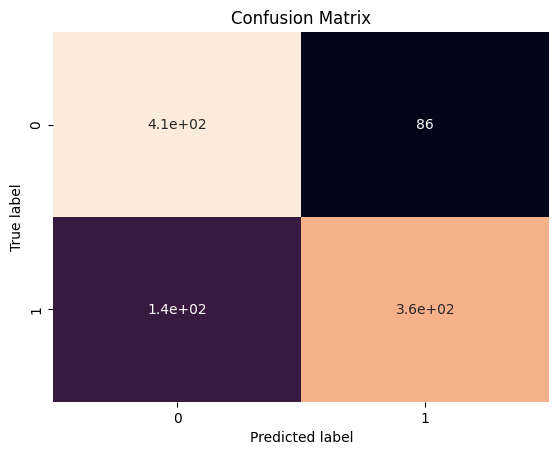

__________ec__________
Accuracy 0.906
Precision: 0.984000
Recall: 0.851211
F1 score: 0.912801
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       500
           1       0.85      0.98      0.91       500

    accuracy                           0.91      1000
   macro avg       0.92      0.91      0.91      1000
weighted avg       0.92      0.91      0.91      1000



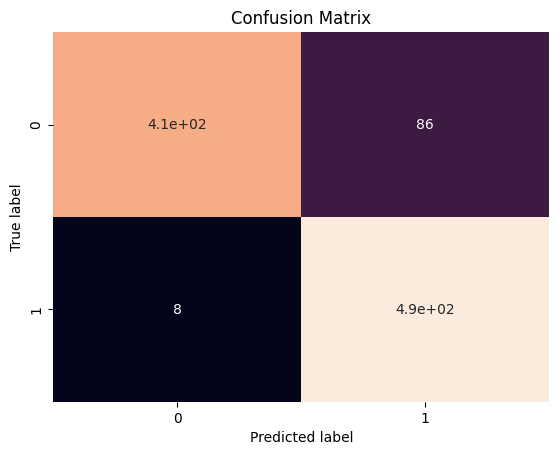

__________vqvae__________
Accuracy 0.885
Precision: 0.942000
Recall: 0.845601
F1 score: 0.891202
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       500
           1       0.85      0.94      0.89       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.88      1000
weighted avg       0.89      0.89      0.88      1000



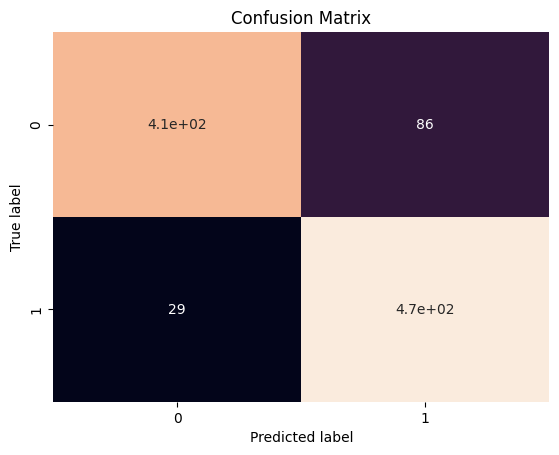



 __________________________________________________ Resnet_101_full __________________________________________________

__________gen__________
Accuracy 0.57
Precision: 0.570000
Recall: 0.570000
F1 score: 0.570000
              precision    recall  f1-score   support

           0       0.57      0.57      0.57       500
           1       0.57      0.57      0.57       500

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.57      1000
weighted avg       0.57      0.57      0.57      1000



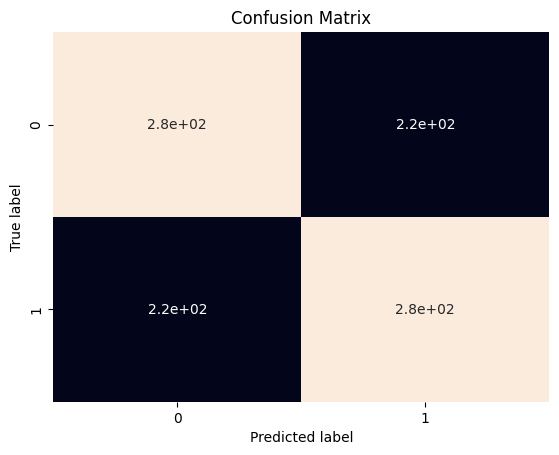

__________ec__________
Accuracy 0.69
Precision: 0.810000
Recall: 0.653226
F1 score: 0.723214
              precision    recall  f1-score   support

           0       0.75      0.57      0.65       500
           1       0.65      0.81      0.72       500

    accuracy                           0.69      1000
   macro avg       0.70      0.69      0.69      1000
weighted avg       0.70      0.69      0.69      1000



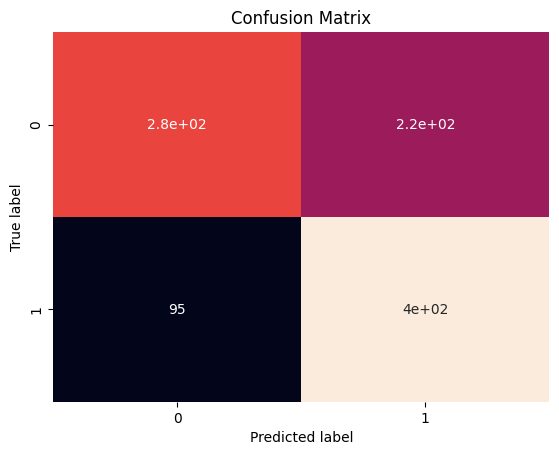

__________vqvae__________
Accuracy 0.499
Precision: 0.428000
Recall: 0.498834
F1 score: 0.460710
              precision    recall  f1-score   support

           0       0.50      0.57      0.53       500
           1       0.50      0.43      0.46       500

    accuracy                           0.50      1000
   macro avg       0.50      0.50      0.50      1000
weighted avg       0.50      0.50      0.50      1000



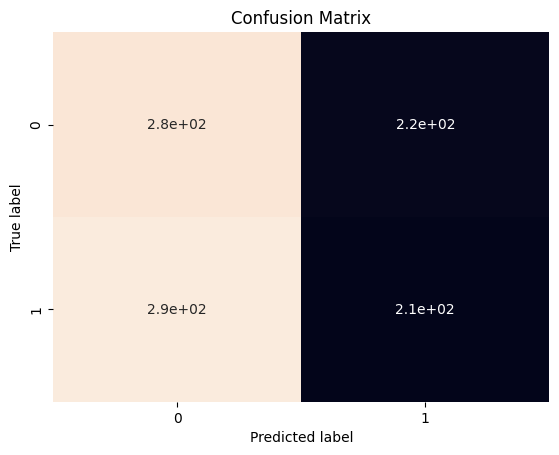



 __________________________________________________ Resnet_50_full __________________________________________________

__________gen__________
Accuracy 0.551
Precision: 0.472000
Recall: 0.560570
F1 score: 0.512486
              precision    recall  f1-score   support

           0       0.54      0.63      0.58       500
           1       0.56      0.47      0.51       500

    accuracy                           0.55      1000
   macro avg       0.55      0.55      0.55      1000
weighted avg       0.55      0.55      0.55      1000



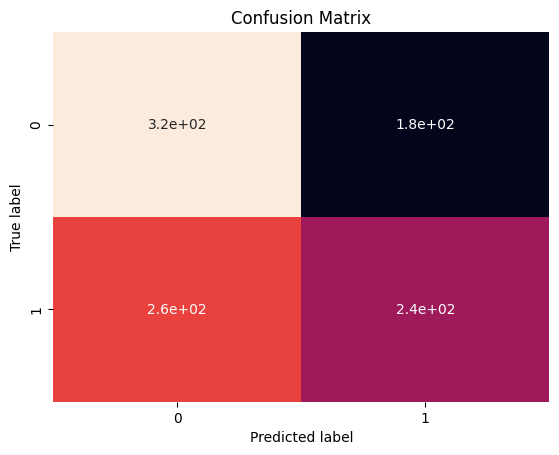

__________ec__________
Accuracy 0.672
Precision: 0.714000
Recall: 0.658672
F1 score: 0.685221
              precision    recall  f1-score   support

           0       0.69      0.63      0.66       500
           1       0.66      0.71      0.69       500

    accuracy                           0.67      1000
   macro avg       0.67      0.67      0.67      1000
weighted avg       0.67      0.67      0.67      1000



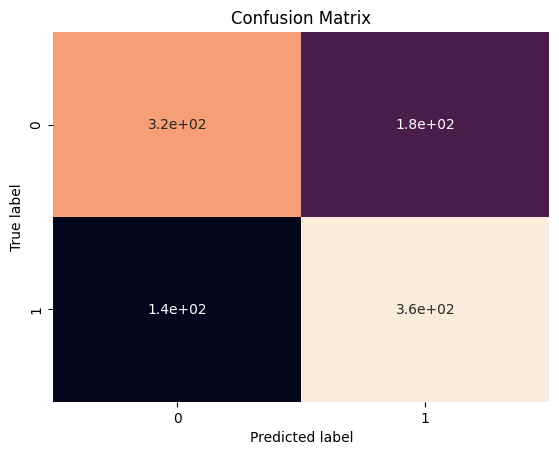

__________vqvae__________
Accuracy 0.53
Precision: 0.430000
Recall: 0.537500
F1 score: 0.477778
              precision    recall  f1-score   support

           0       0.53      0.63      0.57       500
           1       0.54      0.43      0.48       500

    accuracy                           0.53      1000
   macro avg       0.53      0.53      0.53      1000
weighted avg       0.53      0.53      0.53      1000



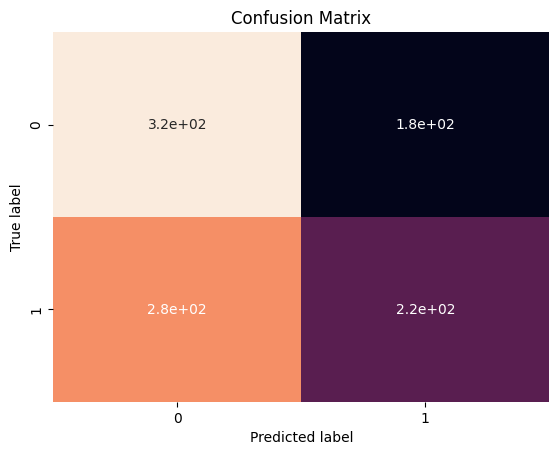



 __________________________________________________ Resnet_152_freeze __________________________________________________

__________gen__________
Accuracy 0.728
Precision: 0.662000
Recall: 0.762673
F1 score: 0.708779
              precision    recall  f1-score   support

           0       0.70      0.79      0.74       500
           1       0.76      0.66      0.71       500

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.73      0.73      0.73      1000



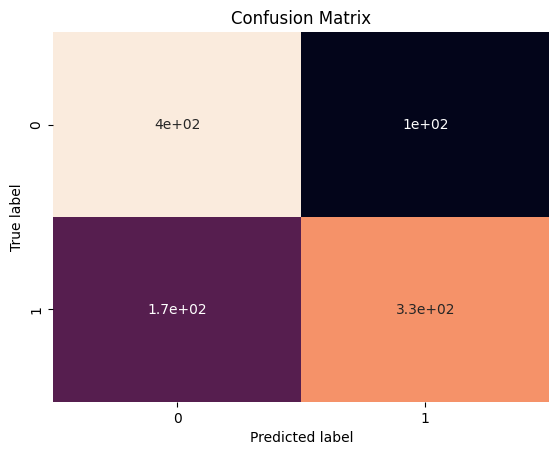

__________ec__________
Accuracy 0.886
Precision: 0.978000
Recall: 0.826014
F1 score: 0.895604
              precision    recall  f1-score   support

           0       0.97      0.79      0.87       500
           1       0.83      0.98      0.90       500

    accuracy                           0.89      1000
   macro avg       0.90      0.89      0.89      1000
weighted avg       0.90      0.89      0.89      1000



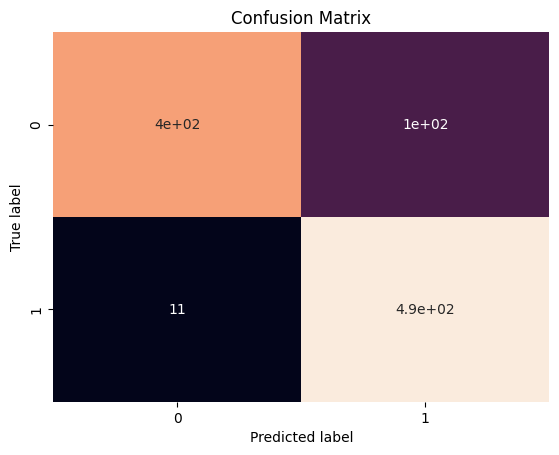

__________vqvae__________
Accuracy 0.871
Precision: 0.948000
Recall: 0.821490
F1 score: 0.880223
              precision    recall  f1-score   support

           0       0.94      0.79      0.86       500
           1       0.82      0.95      0.88       500

    accuracy                           0.87      1000
   macro avg       0.88      0.87      0.87      1000
weighted avg       0.88      0.87      0.87      1000



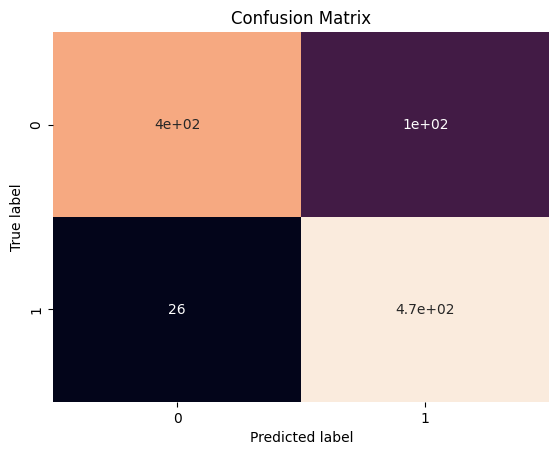



 __________________________________________________ Resnet_101_freeze __________________________________________________

__________gen__________
Accuracy 0.54
Precision: 0.506000
Recall: 0.542918
F1 score: 0.523810
              precision    recall  f1-score   support

           0       0.54      0.57      0.56       500
           1       0.54      0.51      0.52       500

    accuracy                           0.54      1000
   macro avg       0.54      0.54      0.54      1000
weighted avg       0.54      0.54      0.54      1000



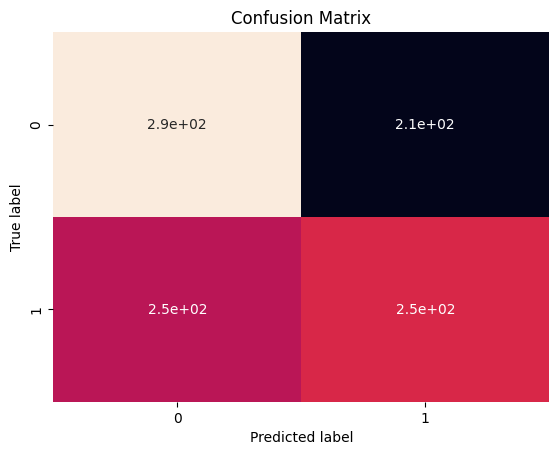

__________ec__________
Accuracy 0.628
Precision: 0.682000
Recall: 0.615523
F1 score: 0.647059
              precision    recall  f1-score   support

           0       0.64      0.57      0.61       500
           1       0.62      0.68      0.65       500

    accuracy                           0.63      1000
   macro avg       0.63      0.63      0.63      1000
weighted avg       0.63      0.63      0.63      1000



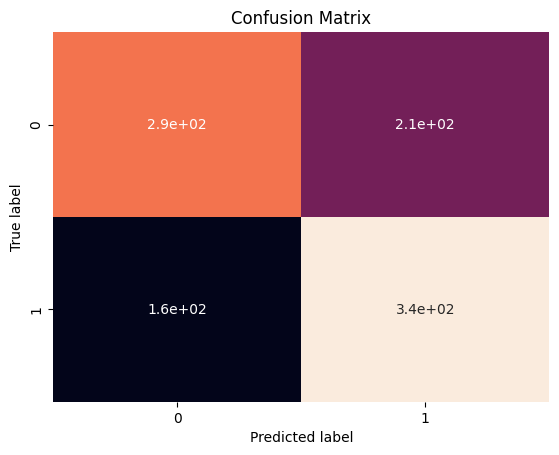

__________vqvae__________
Accuracy 0.523
Precision: 0.472000
Recall: 0.525612
F1 score: 0.497366
              precision    recall  f1-score   support

           0       0.52      0.57      0.55       500
           1       0.53      0.47      0.50       500

    accuracy                           0.52      1000
   macro avg       0.52      0.52      0.52      1000
weighted avg       0.52      0.52      0.52      1000



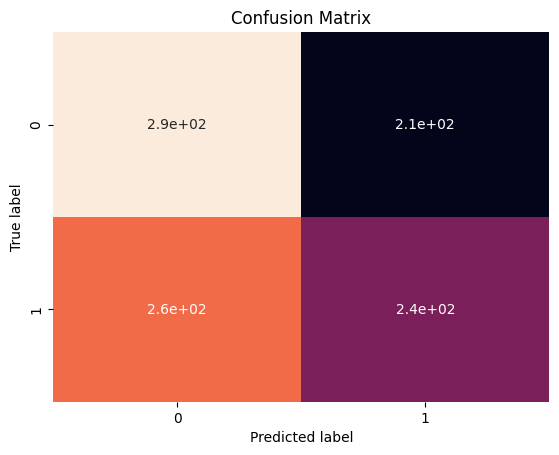



 __________________________________________________ Resnet_50_freeze __________________________________________________

__________gen__________
Accuracy 0.57
Precision: 0.524000
Recall: 0.577093
F1 score: 0.549266
              precision    recall  f1-score   support

           0       0.56      0.62      0.59       500
           1       0.58      0.52      0.55       500

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.57      1000
weighted avg       0.57      0.57      0.57      1000



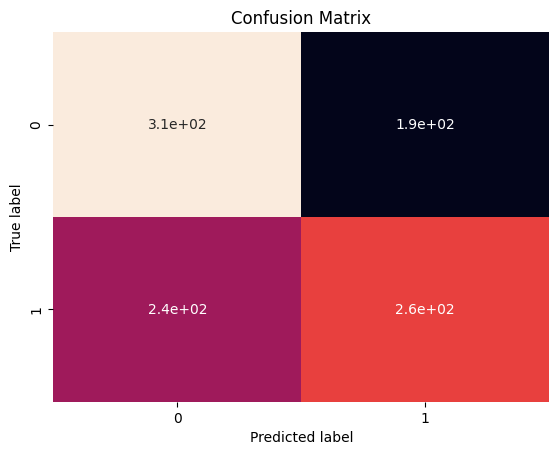

__________ec__________
Accuracy 0.7
Precision: 0.784000
Recall: 0.671233
F1 score: 0.723247
              precision    recall  f1-score   support

           0       0.74      0.62      0.67       500
           1       0.67      0.78      0.72       500

    accuracy                           0.70      1000
   macro avg       0.71      0.70      0.70      1000
weighted avg       0.71      0.70      0.70      1000



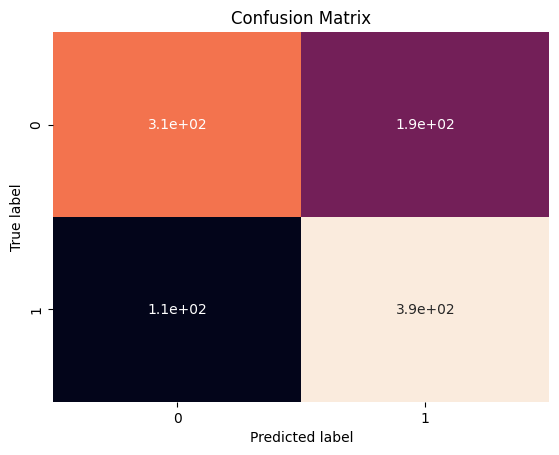

__________vqvae__________
Accuracy 0.535
Precision: 0.454000
Recall: 0.541766
F1 score: 0.494015
              precision    recall  f1-score   support

           0       0.53      0.62      0.57       500
           1       0.54      0.45      0.49       500

    accuracy                           0.54      1000
   macro avg       0.54      0.54      0.53      1000
weighted avg       0.54      0.54      0.53      1000



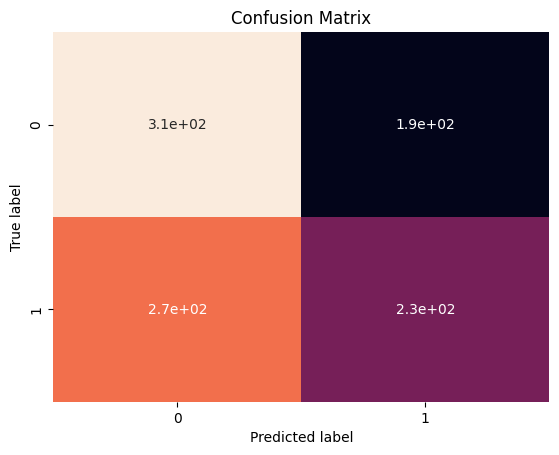



 __________________________________________________ VGG_16_full __________________________________________________

__________gen__________
Accuracy 0.9
Precision: 0.896000
Recall: 0.903226
F1 score: 0.899598
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       500
           1       0.90      0.90      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



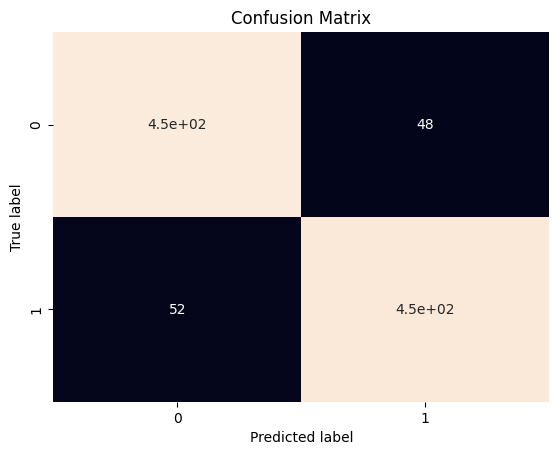

__________ec__________
Accuracy 0.95
Precision: 0.996000
Recall: 0.912088
F1 score: 0.952199
              precision    recall  f1-score   support

           0       1.00      0.90      0.95       500
           1       0.91      1.00      0.95       500

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



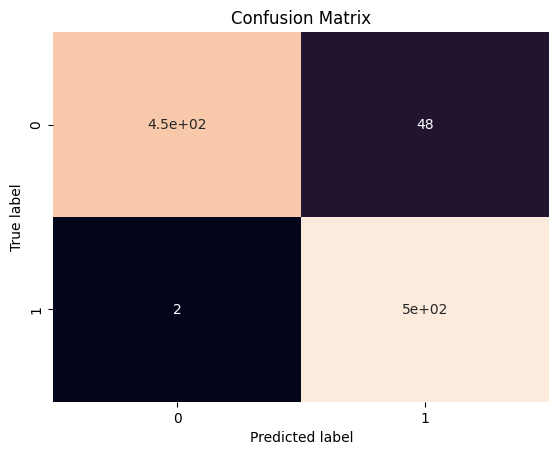

__________vqvae__________
Accuracy 0.934
Precision: 0.964000
Recall: 0.909434
F1 score: 0.935922
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       500
           1       0.91      0.96      0.94       500

    accuracy                           0.93      1000
   macro avg       0.94      0.93      0.93      1000
weighted avg       0.94      0.93      0.93      1000



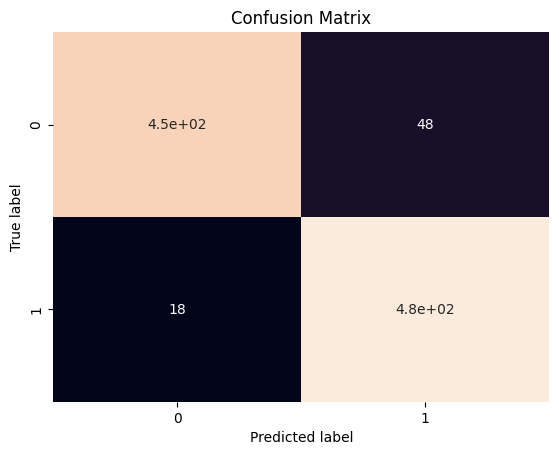



 __________________________________________________ VGG_19_full __________________________________________________

__________gen__________
Accuracy 0.916
Precision: 0.910000
Recall: 0.921053
F1 score: 0.915493
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       500
           1       0.92      0.91      0.92       500

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



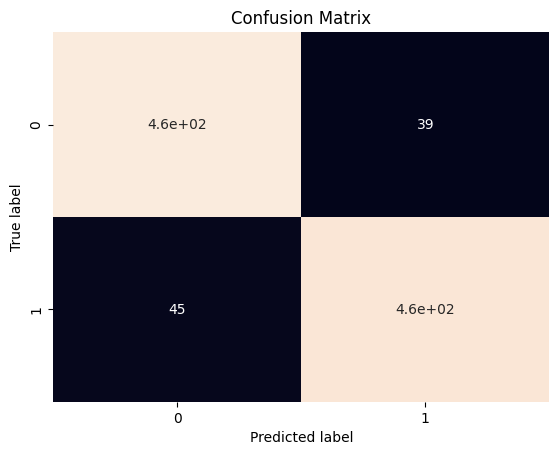

__________ec__________
Accuracy 0.96
Precision: 0.998000
Recall: 0.927509
F1 score: 0.961464
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       500
           1       0.93      1.00      0.96       500

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



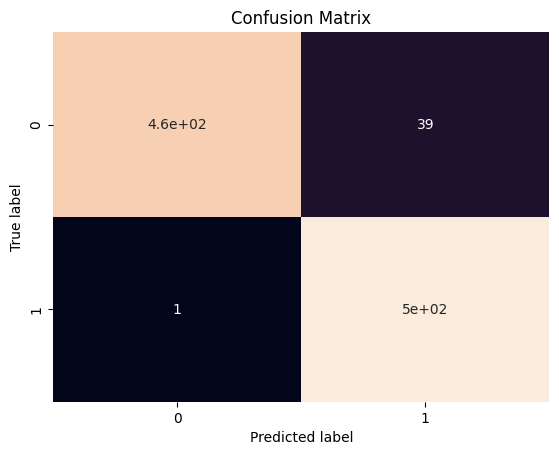

__________vqvae__________
Accuracy 0.942
Precision: 0.962000
Recall: 0.925000
F1 score: 0.943137
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       500
           1       0.93      0.96      0.94       500

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



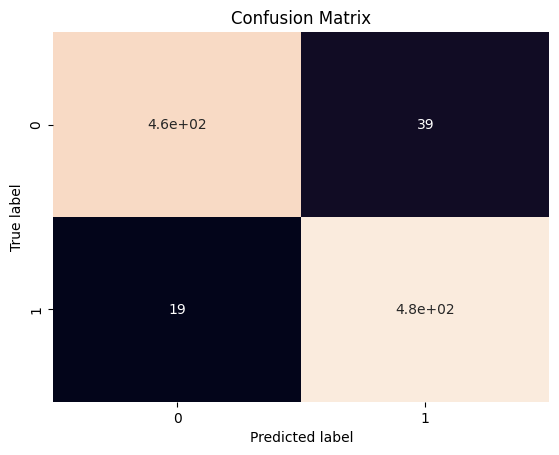



 __________________________________________________ VGG_16_freeze __________________________________________________

__________gen__________
Accuracy 0.603
Precision: 0.542000
Recall: 0.617312
F1 score: 0.577210
              precision    recall  f1-score   support

           0       0.59      0.66      0.63       500
           1       0.62      0.54      0.58       500

    accuracy                           0.60      1000
   macro avg       0.60      0.60      0.60      1000
weighted avg       0.60      0.60      0.60      1000



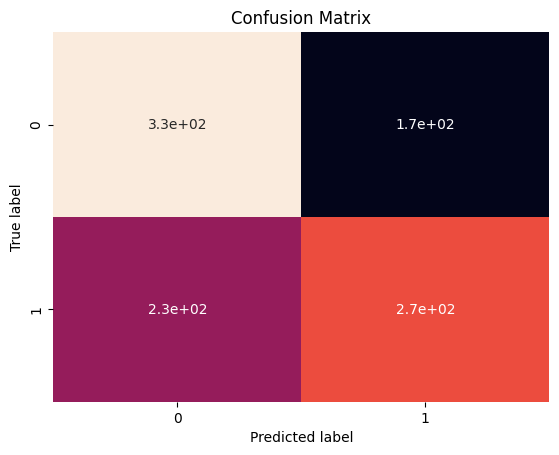

__________ec__________
Accuracy 0.74
Precision: 0.816000
Recall: 0.708333
F1 score: 0.758364
              precision    recall  f1-score   support

           0       0.78      0.66      0.72       500
           1       0.71      0.82      0.76       500

    accuracy                           0.74      1000
   macro avg       0.75      0.74      0.74      1000
weighted avg       0.75      0.74      0.74      1000



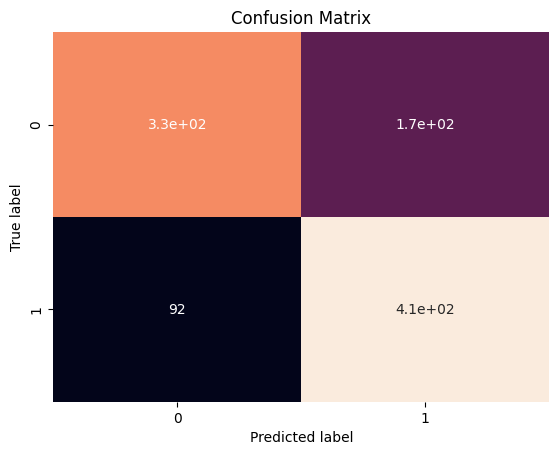

__________vqvae__________
Accuracy 0.736
Precision: 0.808000
Recall: 0.706294
F1 score: 0.753731
              precision    recall  f1-score   support

           0       0.78      0.66      0.72       500
           1       0.71      0.81      0.75       500

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.73      1000
weighted avg       0.74      0.74      0.73      1000



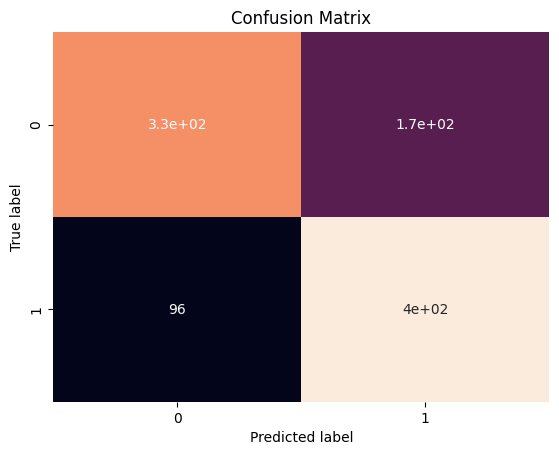



 __________________________________________________ VGG_19_freeze __________________________________________________

__________gen__________
Accuracy 0.583
Precision: 0.512000
Recall: 0.596737
F1 score: 0.551130
              precision    recall  f1-score   support

           0       0.57      0.65      0.61       500
           1       0.60      0.51      0.55       500

    accuracy                           0.58      1000
   macro avg       0.58      0.58      0.58      1000
weighted avg       0.58      0.58      0.58      1000



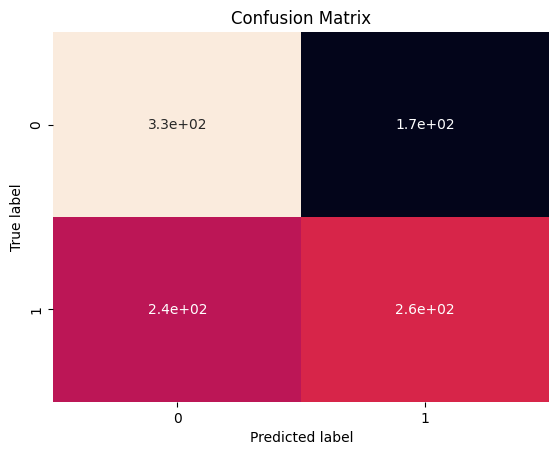

__________ec__________
Accuracy 0.685
Precision: 0.716000
Recall: 0.674200
F1 score: 0.694471
              precision    recall  f1-score   support

           0       0.70      0.65      0.67       500
           1       0.67      0.72      0.69       500

    accuracy                           0.69      1000
   macro avg       0.69      0.69      0.68      1000
weighted avg       0.69      0.69      0.68      1000



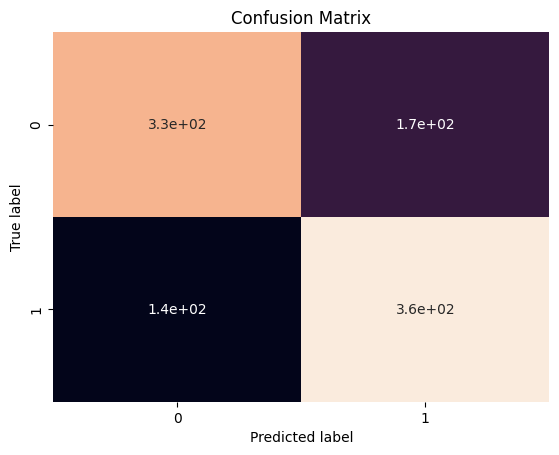

__________vqvae__________
Accuracy 0.707
Precision: 0.760000
Recall: 0.687161
F1 score: 0.721747
              precision    recall  f1-score   support

           0       0.73      0.65      0.69       500
           1       0.69      0.76      0.72       500

    accuracy                           0.71      1000
   macro avg       0.71      0.71      0.71      1000
weighted avg       0.71      0.71      0.71      1000



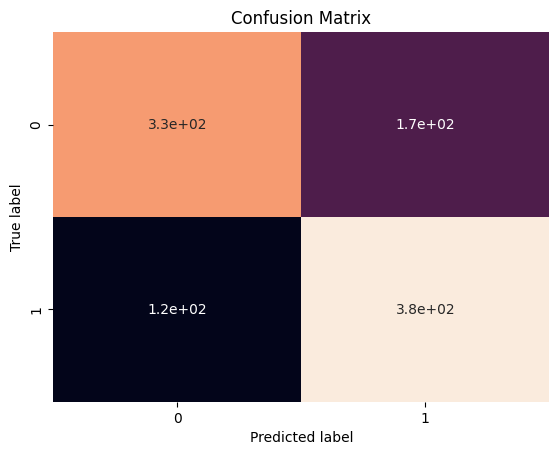

In [ ]:
for model_name in model_softmax.keys():
  print("\n\n","_"*50, model_name, "_"*50, end = "\n\n")

  for key in model_data[model_name].keys():
    Xtest = batch_predict(model_softmax[model_name].headless_model, model_data[model_name][key].images, 64)
    y_result = model_elm[model_name].predict(Xtest)

    labels = model_data[model_name][key].labels
    print(f"{'_'*10}{key}{'_'*10}")
    print("Accuracy", accuracy_score(y_result, labels))

    # precision tp / (tp + fp)
    precision = precision_score(y_result, labels)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_result, labels)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_result, labels)
    print('F1 score: %f' % f1)

    print(classification_report(labels, y_result))

    cm8 = confusion_matrix(labels, y_result)
    sns.heatmap(cm8, annot=True, cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

## Testing SVM



 __________________________________________________ Resnet_152_full __________________________________________________

__________gen__________
Accuracy 0.793
Precision: 0.738000
Recall: 0.829213
F1 score: 0.780952
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       500
           1       0.83      0.74      0.78       500

    accuracy                           0.79      1000
   macro avg       0.80      0.79      0.79      1000
weighted avg       0.80      0.79      0.79      1000



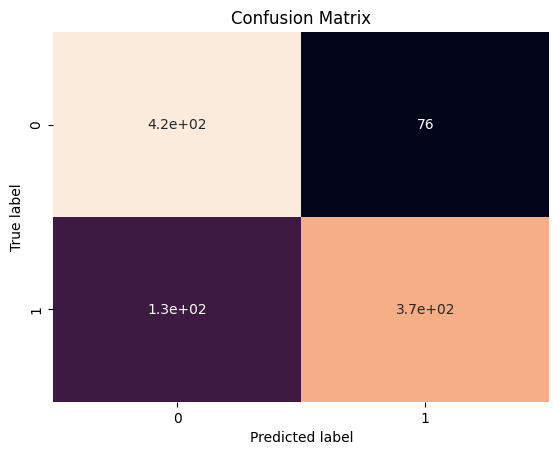

__________ec__________
Accuracy 0.921
Precision: 0.994000
Recall: 0.867365
F1 score: 0.926375
              precision    recall  f1-score   support

           0       0.99      0.85      0.91       500
           1       0.87      0.99      0.93       500

    accuracy                           0.92      1000
   macro avg       0.93      0.92      0.92      1000
weighted avg       0.93      0.92      0.92      1000



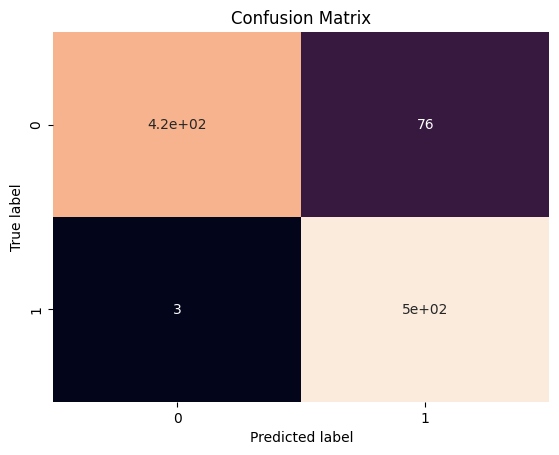

__________vqvae__________
Accuracy 0.904
Precision: 0.960000
Recall: 0.863309
F1 score: 0.909091
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       500
           1       0.86      0.96      0.91       500

    accuracy                           0.90      1000
   macro avg       0.91      0.90      0.90      1000
weighted avg       0.91      0.90      0.90      1000



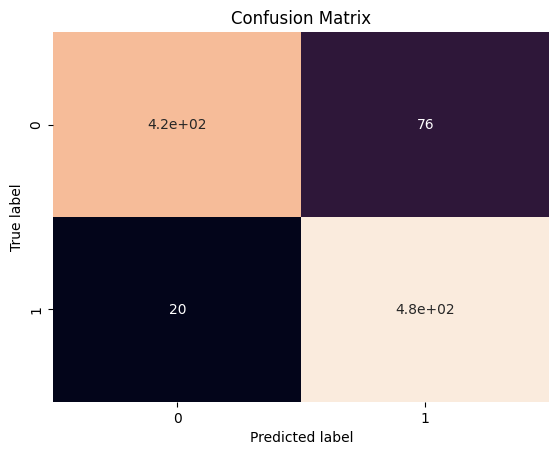



 __________________________________________________ Resnet_101_full __________________________________________________

__________gen__________
Accuracy 0.579
Precision: 0.536000
Recall: 0.586433
F1 score: 0.560084
              precision    recall  f1-score   support

           0       0.57      0.62      0.60       500
           1       0.59      0.54      0.56       500

    accuracy                           0.58      1000
   macro avg       0.58      0.58      0.58      1000
weighted avg       0.58      0.58      0.58      1000



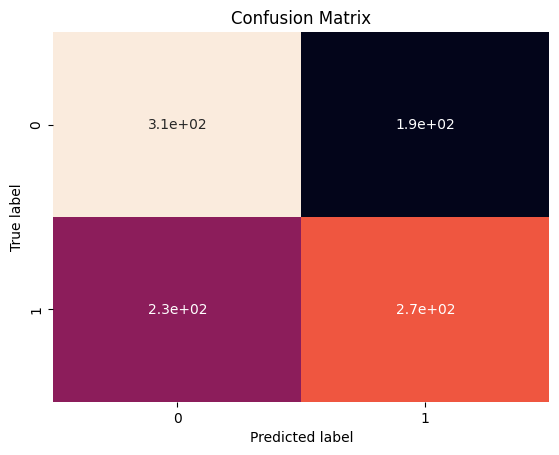

__________ec__________
Accuracy 0.731
Precision: 0.840000
Recall: 0.689655
F1 score: 0.757439
              precision    recall  f1-score   support

           0       0.80      0.62      0.70       500
           1       0.69      0.84      0.76       500

    accuracy                           0.73      1000
   macro avg       0.74      0.73      0.73      1000
weighted avg       0.74      0.73      0.73      1000



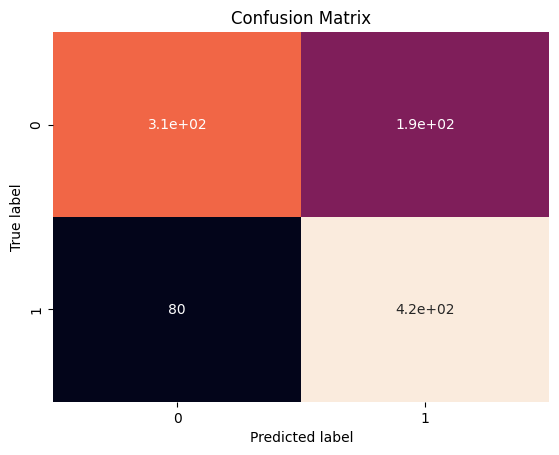

__________vqvae__________
Accuracy 0.528
Precision: 0.434000
Recall: 0.534483
F1 score: 0.479029
              precision    recall  f1-score   support

           0       0.52      0.62      0.57       500
           1       0.53      0.43      0.48       500

    accuracy                           0.53      1000
   macro avg       0.53      0.53      0.52      1000
weighted avg       0.53      0.53      0.52      1000



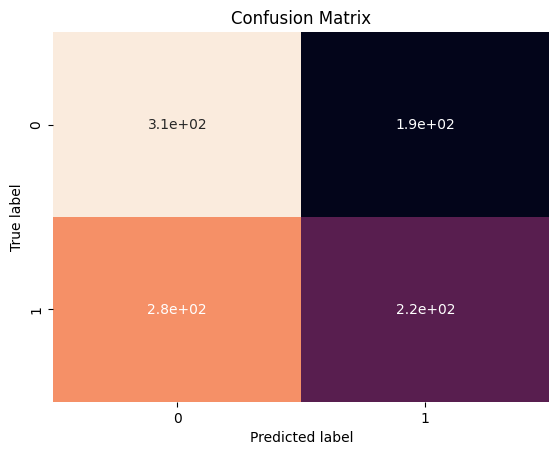



 __________________________________________________ Resnet_50_full __________________________________________________

__________gen__________
Accuracy 0.575
Precision: 0.516000
Recall: 0.585034
F1 score: 0.548353
              precision    recall  f1-score   support

           0       0.57      0.63      0.60       500
           1       0.59      0.52      0.55       500

    accuracy                           0.57      1000
   macro avg       0.58      0.57      0.57      1000
weighted avg       0.58      0.57      0.57      1000



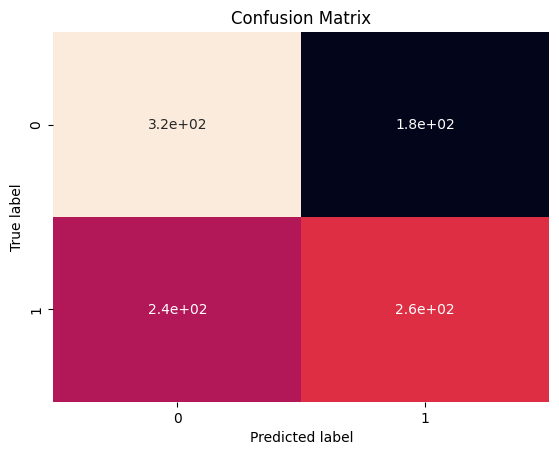

__________ec__________
Accuracy 0.722
Precision: 0.810000
Recall: 0.688776
F1 score: 0.744485
              precision    recall  f1-score   support

           0       0.77      0.63      0.70       500
           1       0.69      0.81      0.74       500

    accuracy                           0.72      1000
   macro avg       0.73      0.72      0.72      1000
weighted avg       0.73      0.72      0.72      1000



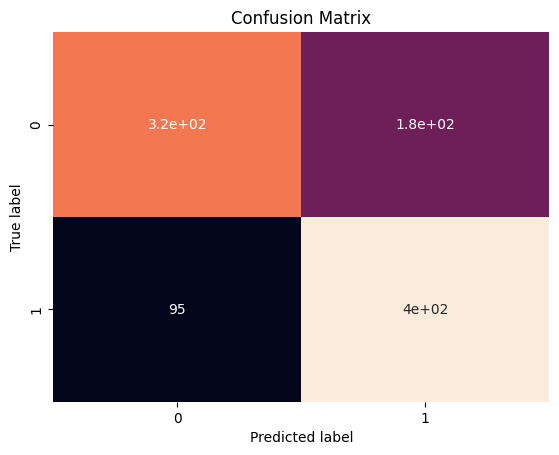

__________vqvae__________
Accuracy 0.568
Precision: 0.502000
Recall: 0.578341
F1 score: 0.537473
              precision    recall  f1-score   support

           0       0.56      0.63      0.59       500
           1       0.58      0.50      0.54       500

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.57      1000
weighted avg       0.57      0.57      0.57      1000



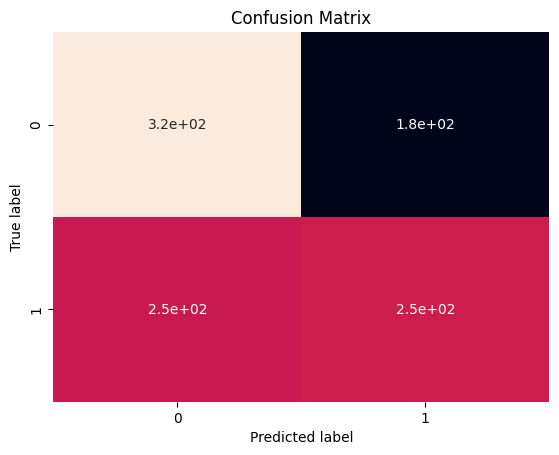



 __________________________________________________ Resnet_152_freeze __________________________________________________

__________gen__________
Accuracy 0.764
Precision: 0.698000
Recall: 0.804147
F1 score: 0.747323
              precision    recall  f1-score   support

           0       0.73      0.83      0.78       500
           1       0.80      0.70      0.75       500

    accuracy                           0.76      1000
   macro avg       0.77      0.76      0.76      1000
weighted avg       0.77      0.76      0.76      1000



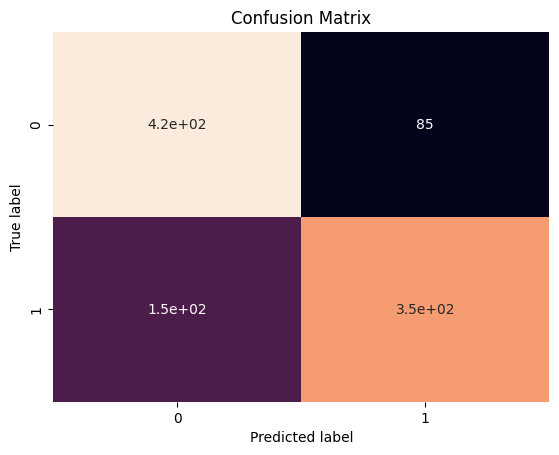

__________ec__________
Accuracy 0.909
Precision: 0.988000
Recall: 0.853195
F1 score: 0.915663
              precision    recall  f1-score   support

           0       0.99      0.83      0.90       500
           1       0.85      0.99      0.92       500

    accuracy                           0.91      1000
   macro avg       0.92      0.91      0.91      1000
weighted avg       0.92      0.91      0.91      1000



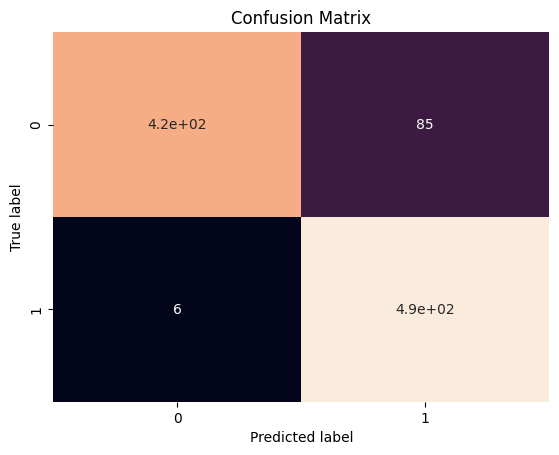

__________vqvae__________
Accuracy 0.89
Precision: 0.950000
Recall: 0.848214
F1 score: 0.896226
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       500
           1       0.85      0.95      0.90       500

    accuracy                           0.89      1000
   macro avg       0.90      0.89      0.89      1000
weighted avg       0.90      0.89      0.89      1000



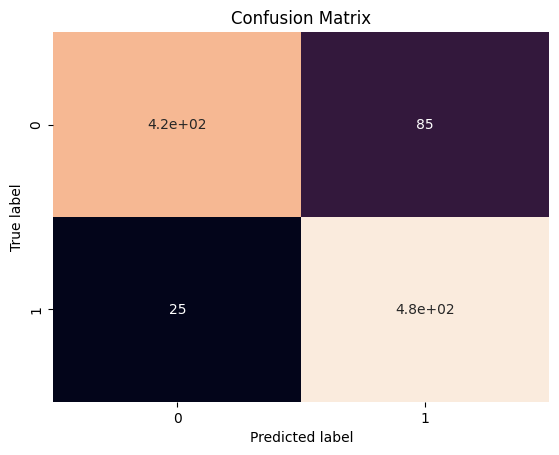



 __________________________________________________ Resnet_101_freeze __________________________________________________

__________gen__________
Accuracy 0.585
Precision: 0.572000
Recall: 0.587269
F1 score: 0.579534
              precision    recall  f1-score   support

           0       0.58      0.60      0.59       500
           1       0.59      0.57      0.58       500

    accuracy                           0.58      1000
   macro avg       0.59      0.58      0.58      1000
weighted avg       0.59      0.58      0.58      1000



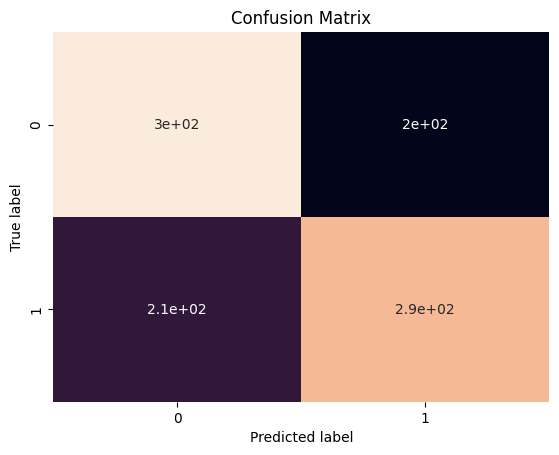

__________ec__________
Accuracy 0.7
Precision: 0.802000
Recall: 0.666113
F1 score: 0.727768
              precision    recall  f1-score   support

           0       0.75      0.60      0.67       500
           1       0.67      0.80      0.73       500

    accuracy                           0.70      1000
   macro avg       0.71      0.70      0.70      1000
weighted avg       0.71      0.70      0.70      1000



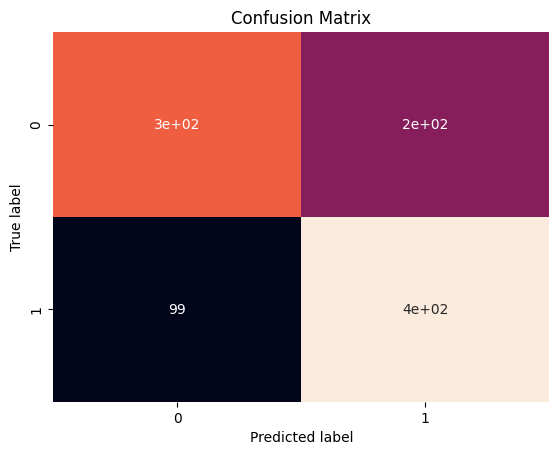

__________vqvae__________
Accuracy 0.548
Precision: 0.498000
Recall: 0.553333
F1 score: 0.524211
              precision    recall  f1-score   support

           0       0.54      0.60      0.57       500
           1       0.55      0.50      0.52       500

    accuracy                           0.55      1000
   macro avg       0.55      0.55      0.55      1000
weighted avg       0.55      0.55      0.55      1000



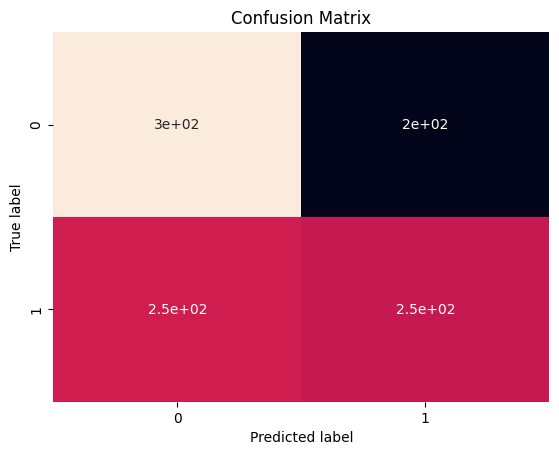



 __________________________________________________ Resnet_50_freeze __________________________________________________

__________gen__________
Accuracy 0.581
Precision: 0.530000
Recall: 0.590200
F1 score: 0.558483
              precision    recall  f1-score   support

           0       0.57      0.63      0.60       500
           1       0.59      0.53      0.56       500

    accuracy                           0.58      1000
   macro avg       0.58      0.58      0.58      1000
weighted avg       0.58      0.58      0.58      1000



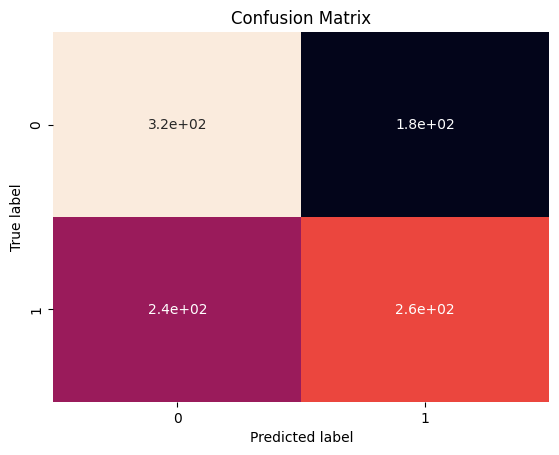

__________ec__________
Accuracy 0.718
Precision: 0.804000
Recall: 0.686007
F1 score: 0.740331
              precision    recall  f1-score   support

           0       0.76      0.63      0.69       500
           1       0.69      0.80      0.74       500

    accuracy                           0.72      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.72      0.72      0.72      1000



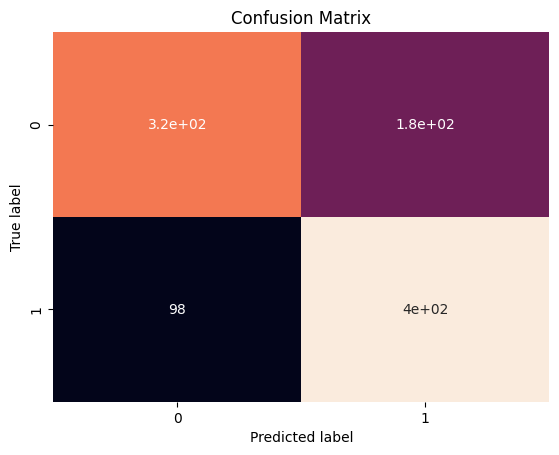

__________vqvae__________
Accuracy 0.557
Precision: 0.482000
Recall: 0.567059
F1 score: 0.521081
              precision    recall  f1-score   support

           0       0.55      0.63      0.59       500
           1       0.57      0.48      0.52       500

    accuracy                           0.56      1000
   macro avg       0.56      0.56      0.55      1000
weighted avg       0.56      0.56      0.55      1000



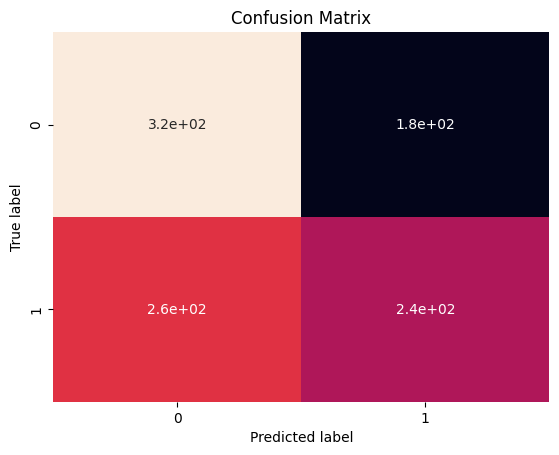



 __________________________________________________ VGG_16_full __________________________________________________

__________gen__________
Accuracy 0.898
Precision: 0.868000
Recall: 0.923404
F1 score: 0.894845
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       500
           1       0.92      0.87      0.89       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



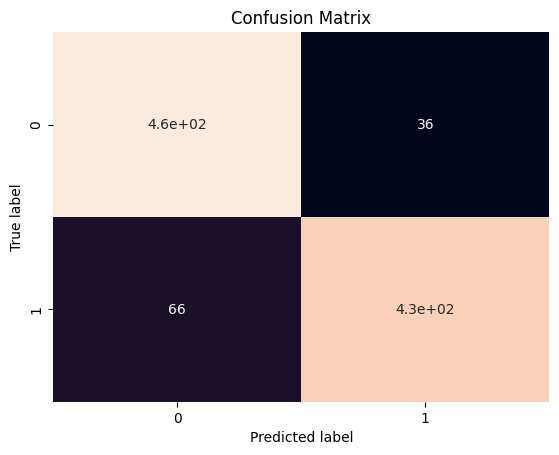

__________ec__________
Accuracy 0.959
Precision: 0.990000
Recall: 0.932203
F1 score: 0.960233
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       500
           1       0.93      0.99      0.96       500

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



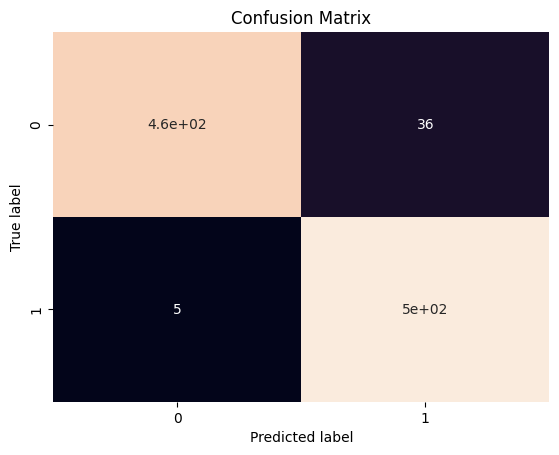

__________vqvae__________
Accuracy 0.945
Precision: 0.962000
Recall: 0.930368
F1 score: 0.945919
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       500
           1       0.93      0.96      0.95       500

    accuracy                           0.94      1000
   macro avg       0.95      0.95      0.94      1000
weighted avg       0.95      0.94      0.94      1000



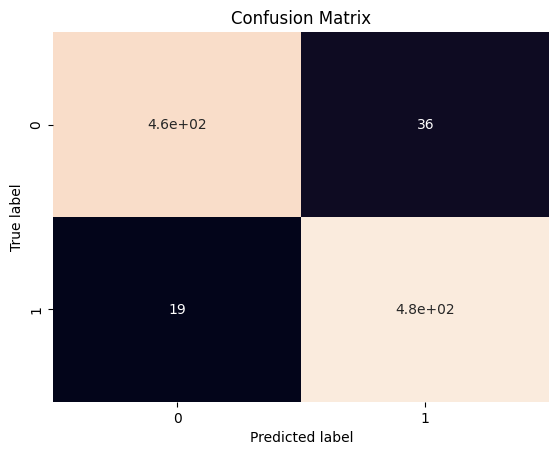



 __________________________________________________ VGG_19_full __________________________________________________

__________gen__________
Accuracy 0.909
Precision: 0.882000
Recall: 0.932347
F1 score: 0.906475
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       500
           1       0.93      0.88      0.91       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



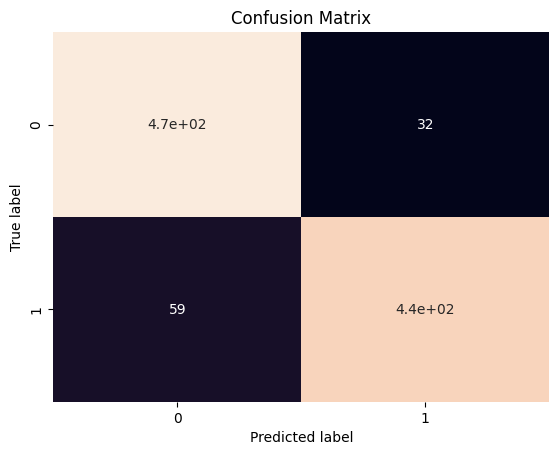

__________ec__________
Accuracy 0.966
Precision: 0.996000
Recall: 0.939623
F1 score: 0.966990
              precision    recall  f1-score   support

           0       1.00      0.94      0.96       500
           1       0.94      1.00      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



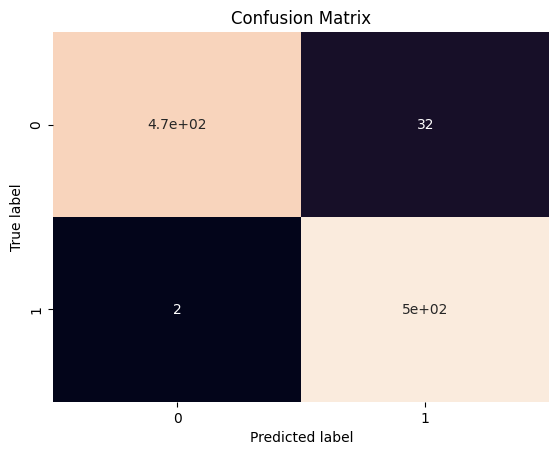

__________vqvae__________
Accuracy 0.946
Precision: 0.956000
Recall: 0.937255
F1 score: 0.946535
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       500
           1       0.94      0.96      0.95       500

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



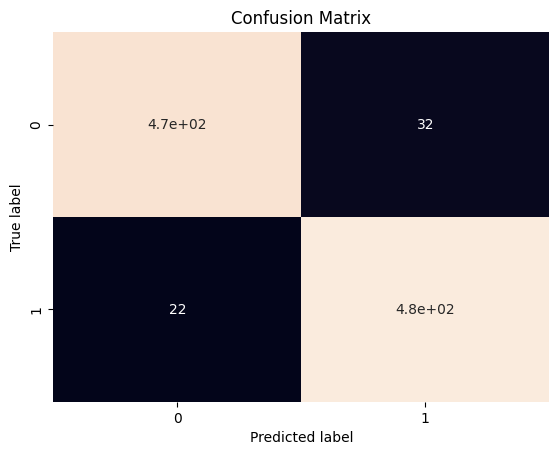



 __________________________________________________ VGG_16_freeze __________________________________________________

__________gen__________
Accuracy 0.613
Precision: 0.498000
Recall: 0.646753
F1 score: 0.562712
              precision    recall  f1-score   support

           0       0.59      0.73      0.65       500
           1       0.65      0.50      0.56       500

    accuracy                           0.61      1000
   macro avg       0.62      0.61      0.61      1000
weighted avg       0.62      0.61      0.61      1000



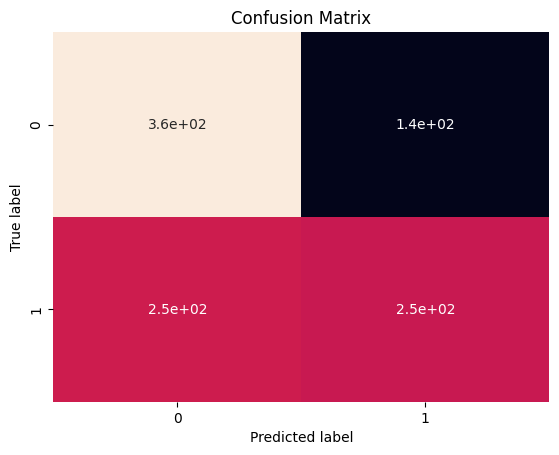

__________ec__________
Accuracy 0.781
Precision: 0.834000
Recall: 0.754069
F1 score: 0.792023
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       500
           1       0.75      0.83      0.79       500

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000



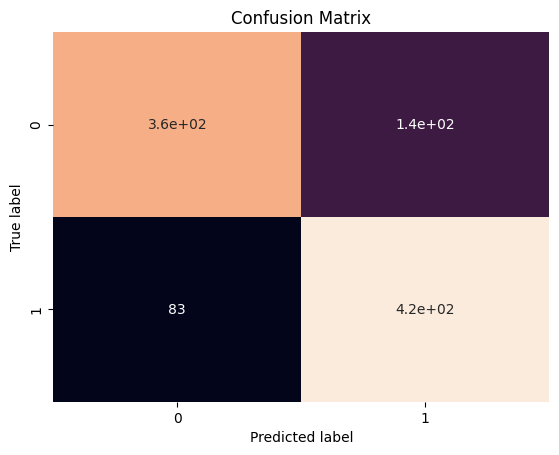

__________vqvae__________
Accuracy 0.771
Precision: 0.814000
Recall: 0.749540
F1 score: 0.780441
              precision    recall  f1-score   support

           0       0.80      0.73      0.76       500
           1       0.75      0.81      0.78       500

    accuracy                           0.77      1000
   macro avg       0.77      0.77      0.77      1000
weighted avg       0.77      0.77      0.77      1000



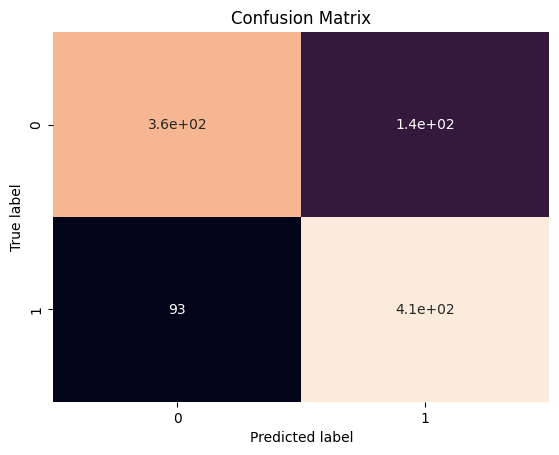



 __________________________________________________ VGG_19_freeze __________________________________________________

__________gen__________
Accuracy 0.606
Precision: 0.528000
Recall: 0.625592
F1 score: 0.572668
              precision    recall  f1-score   support

           0       0.59      0.68      0.63       500
           1       0.63      0.53      0.57       500

    accuracy                           0.61      1000
   macro avg       0.61      0.61      0.60      1000
weighted avg       0.61      0.61      0.60      1000



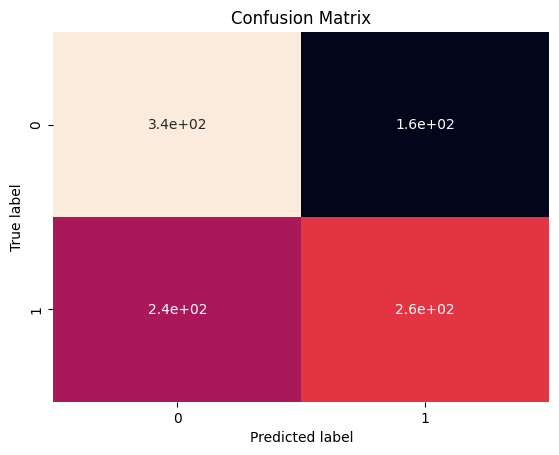

__________ec__________
Accuracy 0.753
Precision: 0.822000
Recall: 0.722320
F1 score: 0.768943
              precision    recall  f1-score   support

           0       0.79      0.68      0.73       500
           1       0.72      0.82      0.77       500

    accuracy                           0.75      1000
   macro avg       0.76      0.75      0.75      1000
weighted avg       0.76      0.75      0.75      1000



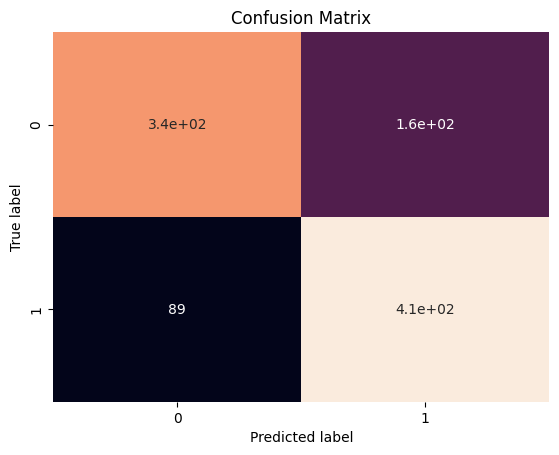

In [ ]:
for model_name in model_softmax.keys():
  print("\n\n","_"*50, model_name, "_"*50, end = "\n\n")

  for key in model_data[model_name].keys():
    Xtest = batch_predict(model_softmax[model_name].headless_model, model_data[model_name][key].images, 64)
    y_result = model_svm[model_name].predict(Xtest)

    labels = model_data[model_name][key].labels
    print(f"{'_'*10}{key}{'_'*10}")
    print("Accuracy", accuracy_score(y_result, labels))

    # precision tp / (tp + fp)
    precision = precision_score(y_result, labels)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_result, labels)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_result, labels)
    print('F1 score: %f' % f1)

    print(classification_report(labels, y_result))

    cm8 = confusion_matrix(labels, y_result)
    sns.heatmap(cm8, annot=True, cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()